# hp_file_extractor

## common

In [1]:
import os
import numpy as np
import pandas as pd
hp_config_format = ['liczba punktów', 'liczba warstw', 'liczba neuronów', 'funkcja aktywacji', 'warstwa wyjściowa']
# hp_stat_columns = ['hp_config','avg(test)','med(test)','std(test)','max(train)','min(train)']
hp_stat_columns = ['hp_config','med(train)','med(test)','std(test)']

def hp_config_split(dataframe):
    duplicates = dataframe[dataframe.duplicated(subset=['hp_config'])].copy()
    if duplicates.empty is False:
        print('duplicated hp_configs:', list(duplicates['hp_config']))
    dataframe = dataframe.copy()
    dataframe.drop_duplicates(subset=['hp_config'], inplace=True)
    dataframe[hp_config_format] = dataframe['hp_config'].str.rsplit('-', n=4, expand=True)
    return dataframe

def construct_df_from_history_files(history_dir, metric='loss', tail_size=20):
    # history_dir = DIRECTORY + 'history/'
    hp_file_rows = []
    history_filenames = list(filter(lambda filename: 'history' in filename, os.listdir(history_dir)))
    for history_filename in history_filenames:
        
        history_df = pd.read_csv(history_dir + history_filename)
        val_metric_tail = history_df[f'val_{metric}'][-tail_size:]
        metric_tail = history_df[f'{metric}'][-tail_size:]
        
        # new_row = {hp_stat_columns[0]:history_filename.rsplit('-', 1)[0],hp_stat_columns[1]:np.average(val_metric_tail),hp_stat_columns[2]:np.median(val_metric_tail),hp_stat_columns[3]:np.std(val_metric_tail),hp_stat_columns[4]:np.max(metric_tail),hp_stat_columns[5]:np.min(metric_tail)}
        new_row = {
            hp_stat_columns[0]: history_filename.rsplit('-', 1)[0],
            hp_stat_columns[1]:np.median(metric_tail),
            hp_stat_columns[2]:np.median(val_metric_tail),
            hp_stat_columns[3]:np.std(val_metric_tail)}
        hp_file_rows.append(new_row)

    hp_df = pd.DataFrame(hp_file_rows, columns=hp_stat_columns)
    hp_df = hp_config_split(hp_df)
    hp_df = hp_df[hp_config_format + hp_stat_columns[1:]]
    return hp_df

def hp_df_transform(df, metric='acc', sort_by='med(test)', ascending=False):
    df = df[~df['hp_config'].str.contains('selu')]
    
    df[['topologia sieci', 'funkcja aktywacji']] = df['hp_config'].str.rsplit('-', n=1, expand=True)
    df.rename(columns={f'val_{metric}-med': 'med(test)', f'train_{metric}-max': 'max(train)', f'val_{metric}-std': 'std(test)'}, inplace=True)
    df = df[['topologia sieci', 'funkcja aktywacji', 'max(train)', 'med(test)', 'std(test)']]

    df['topologia sieci'] = df['topologia sieci'].str.replace('-','x')
    df['funkcja aktywacji'] = df['funkcja aktywacji'].str.replace('_','\_')
    
    return df.sort_values(sort_by, ascending=ascending)

def get_history_filename(df, df_index):
    record = df.loc[df_index]
    return '-'.join([record['liczba punktów'], record['liczba warstw'], record['liczba neuronów'], record['funkcja aktywacji'], record['warstwa wyjściowa'], 'history']) + '.csv'

def prepare_df_to_latex(df, ascending=False):
    latex_df = df.copy()
    latex_df['topologia sieci'] = latex_df['liczba punktów'] + '-' + latex_df['liczba warstw'] + 'x' + latex_df['liczba neuronów']
    latex_df = latex_df[['topologia sieci', 'funkcja aktywacji', 'warstwa wyjściowa', 'med(train)', 'med(test)', 'std(test)']]
    return latex_df.sort_values('med(test)', ascending=ascending)

In [2]:
MAX_ROWS = 20
pd.set_option('display.max_rows', MAX_ROWS)

In [3]:
import sys
ABS_ROOT_DIR_PATH = '/home/rutkowski/dissertation/'
if ABS_ROOT_DIR_PATH not in sys.path:
    sys.path.append(ABS_ROOT_DIR_PATH)

## q

In [4]:
df = construct_df_from_history_files(ABS_ROOT_DIR_PATH + 'trained_models/q/10points/history/', metric='accuracy')
df.sort_values('med(test)', ascending=False)[:MAX_ROWS]

,liczba punktów,liczba warstw,liczba neuronów,funkcja aktywacji,warstwa wyjściowa,med(train),med(test),std(test)
101,10,3,32,pol_tanh,softmax_real_with_abs,0.966029,0.962974,0.024902
86,10,3,64,pol_tanh,softmax_real_with_abs,0.967865,0.962974,0.016071
68,10,2,64,pol_sigmoid,softmax_real_with_abs,0.962892,0.961138,0.025931
57,10,2,64,pol_tanh,softmax_real_with_abs,0.961897,0.960526,0.019294
46,10,2,32,pol_sigmoid,softmax_real_with_abs,0.966182,0.958690,0.032559
21,10,2,32,pol_tanh,softmax_real_with_abs,0.966641,0.956242,0.021410
65,10,3,128,pol_sigmoid,softmax_real_with_abs,0.956389,0.955018,0.016192
23,10,3,32,pol_sigmoid,softmax_of_softmax_real_with_avg,0.948891,0.954406,0.034459
89,10,3,64,pol_sigmoid,softmax_of_softmax_real_with_mult,0.949503,0.954100,0.024072
76,10,3,32,pol_sigmoid,softmax_of_softmax_real_with_mult,0.951798,0.954100,0.031118


In [5]:
# outputlayer_activation_func_space search
df = construct_df_from_history_files(ABS_ROOT_DIR_PATH + 'trained_models/q/1700341579/history/', metric='accuracy')
df.sort_values('med(test)', ascending=False)[:MAX_ROWS]

,liczba punktów,liczba warstw,liczba neuronów,funkcja aktywacji,warstwa wyjściowa,med(train),med(test),std(test)
1,10,2,128,pol_sigmoid,softmax_real_with_abs,0.964116,0.959608,0.017781
27,10,3,128,pol_tanh,softmax_real_with_abs,0.965111,0.956242,0.018327
28,10,3,128,pol_sigmoid,softmax_real_with_abs,0.959220,0.951652,0.017234
8,10,3,128,pol_sigmoid,softmax_of_softmax_real_with_mult,0.953099,0.951346,0.021134
33,10,2,128,pol_sigmoid,softmax_of_softmax_real_with_avg,0.954476,0.951040,0.017052
31,10,3,128,pol_tanh,softmax_of_softmax_real_with_mult,0.955471,0.950734,0.017942
14,10,2,128,pol_tanh,softmax_real_with_mult,0.953558,0.949510,0.008388
41,10,3,128,pol_tanh,softmax_of_softmax_real_with_avg,0.956159,0.948286,0.032147
20,10,3,128,pol_sigmoid,sigmoid_real,0.954323,0.947674,0.028191
37,10,2,128,pol_sigmoid,softmax_of_softmax_real_with_mult,0.958454,0.946450,0.017322


In [6]:
# small number of neurons search
df = construct_df_from_history_files(ABS_ROOT_DIR_PATH + 'trained_models/q/1700514700/history/', metric='accuracy')
df.sort_values('med(test)', ascending=False)[:MAX_ROWS]

,liczba punktów,liczba warstw,liczba neuronów,funkcja aktywacji,warstwa wyjściowa,med(train),med(test),std(test)
36,10,2,16,pol_sigmoid,softmax_real_with_abs,0.975899,0.974602,0.016826
14,10,3,16,pol_tanh,softmax_real_with_abs,0.978424,0.972766,0.016208
40,10,2,16,pol_tanh,softmax_real_with_abs,0.975440,0.972154,0.015124
24,10,3,16,pol_sigmoid,softmax_real_with_mult,0.971691,0.970930,0.020852
30,10,2,64,pol_sigmoid,softmax_real_with_abs,0.974598,0.969094,0.015927
37,10,2,64,pol_sigmoid,softmax_real_with_mult,0.973833,0.967564,0.013173
23,10,2,32,pol_sigmoid,softmax_real_with_avg,0.970849,0.966340,0.024490
4,10,3,16,pol_sigmoid,softmax_real_with_avg,0.966029,0.964198,0.034585
1,10,2,64,pol_sigmoid,softmax_real_with_avg,0.971614,0.963892,0.008305
26,10,3,16,pol_tanh,softmax_real_with_mult,0.969931,0.962056,0.015300


In [7]:
# small number of neurons search
df = construct_df_from_history_files(ABS_ROOT_DIR_PATH + 'trained_models/q/1700514700/history/', metric='accuracy')
df.sort_values('med(test)', ascending=False)[:MAX_ROWS]

,liczba punktów,liczba warstw,liczba neuronów,funkcja aktywacji,warstwa wyjściowa,med(train),med(test),std(test)
36,10,2,16,pol_sigmoid,softmax_real_with_abs,0.975899,0.974602,0.016826
14,10,3,16,pol_tanh,softmax_real_with_abs,0.978424,0.972766,0.016208
40,10,2,16,pol_tanh,softmax_real_with_abs,0.975440,0.972154,0.015124
24,10,3,16,pol_sigmoid,softmax_real_with_mult,0.971691,0.970930,0.020852
30,10,2,64,pol_sigmoid,softmax_real_with_abs,0.974598,0.969094,0.015927
37,10,2,64,pol_sigmoid,softmax_real_with_mult,0.973833,0.967564,0.013173
23,10,2,32,pol_sigmoid,softmax_real_with_avg,0.970849,0.966340,0.024490
4,10,3,16,pol_sigmoid,softmax_real_with_avg,0.966029,0.964198,0.034585
1,10,2,64,pol_sigmoid,softmax_real_with_avg,0.971614,0.963892,0.008305
26,10,3,16,pol_tanh,softmax_real_with_mult,0.969931,0.962056,0.015300


In [8]:
df = construct_df_from_history_files(ABS_ROOT_DIR_PATH + 'trained_models/q/1701449070/history/', metric='accuracy')
df.sort_values('med(test)', ascending=False)[:MAX_ROWS]

,liczba punktów,liczba warstw,liczba neuronów,funkcja aktywacji,warstwa wyjściowa,med(train),med(test),std(test)
3,10,3,16,pol_sigmoid,softmax_real_with_avg,0.960291,0.956242,0.013468
21,10,3,16,pol_tanh,softmax_real_with_abs,0.956542,0.956242,0.028024
16,10,3,16,pol_sigmoid,softmax_real_with_abs,0.954782,0.953794,0.019233
54,10,3,64,pol_tanh,softmax_real_with_abs,0.960214,0.953182,0.024247
45,10,2,64,pol_sigmoid,softmax_real_with_abs,0.955853,0.948898,0.013128
58,10,2,16,pol_sigmoid,softmax_real_with_abs,0.947054,0.945532,0.021760
11,10,3,64,pol_sigmoid,softmax_real_with_abs,0.949579,0.944002,0.041611
60,10,3,64,pol_sigmoid,softmax_real_with_mult,0.929916,0.943696,0.015366
0,10,3,16,pol_tanh,softmax_real_with_avg,0.940704,0.936964,0.054512
40,10,2,64,pol_tanh,softmax_real_with_abs,0.955700,0.936659,0.017494


99th percentile of train accuracy:       9.6833e-01
99th percentile of validation accuracy:  9.8776e-01


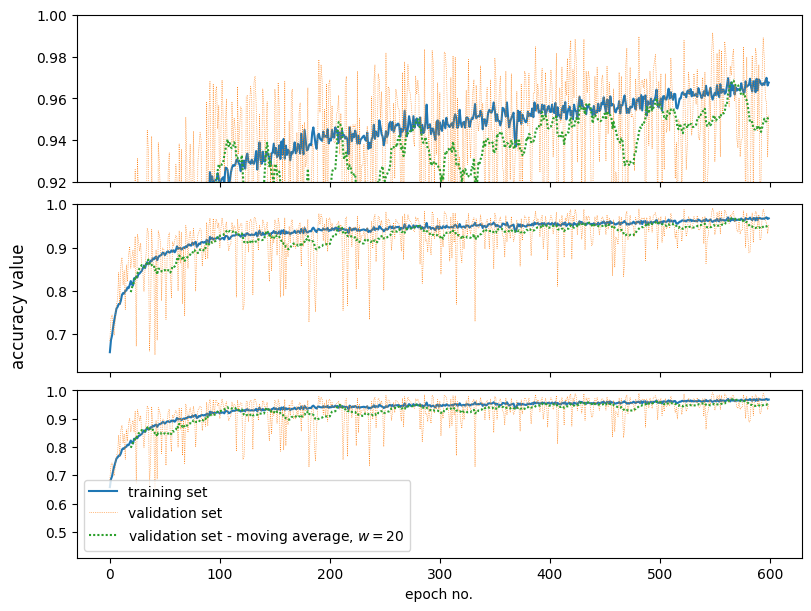

In [9]:
from common.plot import plot_metric_history_zoomed
history_df = pd.read_csv(ABS_ROOT_DIR_PATH + 'trained_models/q/1700514700/history/10-3-16-pol_sigmoid-softmax_real_with_abs-history.csv')
plot_metric_history_zoomed(history_df, metric='accuracy', mode='max', moving_average_window=(20,), threshold_multiplier=0.95)

In [10]:
q_first_df = construct_df_from_history_files(ABS_ROOT_DIR_PATH + 'trained_models/q/1st-search/history/', metric='accuracy')
q_first_df.sort_values('med(test)', ascending=False)[:MAX_ROWS]

,liczba punktów,liczba warstw,liczba neuronów,funkcja aktywacji,warstwa wyjściowa,med(train),med(test),std(test)
56,10,2,64,pol_sigmoid,softmax_real_with_abs,0.953940,0.947674,0.045147
72,10,2,64,pol_tanh,softmax_real_with_avg,0.941622,0.942778,0.029412
73,10,2,16,pol_sigmoid,softmax_real_with_abs,0.956848,0.941554,0.042691
76,10,2,16,pol_sigmoid,softmax_real_with_mult,0.940857,0.936047,0.039965
35,10,2,16,pol_tanh,softmax_real_with_mult,0.948585,0.934211,0.030507
79,10,2,16,pol_tanh,softmax_real_with_abs,0.944989,0.928703,0.038530
69,10,2,16,pol_sigmoid,softmax_real_with_avg,0.926932,0.927479,0.030149
1,10,2,64,pol_sigmoid,softmax_real_with_avg,0.936649,0.926255,0.026636
48,10,2,64,pol_tanh,softmax_real_with_abs,0.945830,0.925949,0.031156
31,10,2,16,pol_tanh,softmax_real_with_avg,0.919663,0.922583,0.045596


In [11]:
print(prepare_df_to_latex(q_first_df).to_latex(index=False, float_format="{:.2%}".format))

\begin{tabular}{lllrrr}
\toprule
topologia sieci & funkcja aktywacji & warstwa wyjściowa & med(train) & med(test) & std(test) \\
\midrule
10-2x64 & pol_sigmoid & softmax_real_with_abs & 95.39% & 94.77% & 4.51% \\
10-2x64 & pol_tanh & softmax_real_with_avg & 94.16% & 94.28% & 2.94% \\
10-2x16 & pol_sigmoid & softmax_real_with_abs & 95.68% & 94.16% & 4.27% \\
10-2x16 & pol_sigmoid & softmax_real_with_mult & 94.09% & 93.60% & 4.00% \\
10-2x16 & pol_tanh & softmax_real_with_mult & 94.86% & 93.42% & 3.05% \\
10-2x16 & pol_tanh & softmax_real_with_abs & 94.50% & 92.87% & 3.85% \\
10-2x16 & pol_sigmoid & softmax_real_with_avg & 92.69% & 92.75% & 3.01% \\
10-2x64 & pol_sigmoid & softmax_real_with_avg & 93.66% & 92.63% & 2.66% \\
10-2x64 & pol_tanh & softmax_real_with_abs & 94.58% & 92.59% & 3.12% \\
10-2x16 & pol_tanh & softmax_real_with_avg & 91.97% & 92.26% & 4.56% \\
10-2x64 & pol_tanh & softmax_real_with_mult & 93.85% & 92.23% & 4.13% \\
10-2x64 & pol_sigmoid & softmax_real_with_mult & 93.

In [12]:
q_second_df = construct_df_from_history_files(ABS_ROOT_DIR_PATH + 'trained_models/q/2nd-search/history/', metric='accuracy')
q_second_df.sort_values('med(test)', ascending=False)[:MAX_ROWS]

,liczba punktów,liczba warstw,liczba neuronów,funkcja aktywacji,warstwa wyjściowa,med(train),med(test),std(test)
17,10,3,64,pol_sigmoid,softmax_real_with_avg,0.956771,0.958996,0.013322
21,10,2,64,pol_tanh,softmax_real_with_abs,0.968095,0.958690,0.019226
30,10,3,64,pol_sigmoid,softmax_real_with_mult,0.955241,0.957772,0.017312
23,10,3,128,pol_tanh,softmax_real_with_abs,0.969702,0.957772,0.009875
25,10,2,64,pol_sigmoid,softmax_real_with_abs,0.964040,0.956854,0.008385
34,10,3,32,pol_sigmoid,softmax_real_with_mult,0.955624,0.956548,0.026895
35,10,3,128,pol_sigmoid,softmax_real_with_avg,0.958378,0.955630,0.025018
8,10,2,32,pol_tanh,softmax_real_with_abs,0.963275,0.955630,0.026695
6,10,3,64,pol_sigmoid,softmax_real_with_abs,0.961285,0.955630,0.048495
1,10,2,128,pol_sigmoid,softmax_real_with_abs,0.964881,0.955324,0.008839


In [13]:
print(prepare_df_to_latex(q_second_df).to_latex(index=False, float_format="{:.2%}".format))

\begin{tabular}{lllrrr}
\toprule
topologia sieci & funkcja aktywacji & warstwa wyjściowa & med(train) & med(test) & std(test) \\
\midrule
10-3x64 & pol_sigmoid & softmax_real_with_avg & 95.68% & 95.90% & 1.33% \\
10-2x64 & pol_tanh & softmax_real_with_abs & 96.81% & 95.87% & 1.92% \\
10-3x64 & pol_sigmoid & softmax_real_with_mult & 95.52% & 95.78% & 1.73% \\
10-3x128 & pol_tanh & softmax_real_with_abs & 96.97% & 95.78% & 0.99% \\
10-2x64 & pol_sigmoid & softmax_real_with_abs & 96.40% & 95.69% & 0.84% \\
10-3x32 & pol_sigmoid & softmax_real_with_mult & 95.56% & 95.65% & 2.69% \\
10-3x128 & pol_sigmoid & softmax_real_with_avg & 95.84% & 95.56% & 2.50% \\
10-2x32 & pol_tanh & softmax_real_with_abs & 96.33% & 95.56% & 2.67% \\
10-3x64 & pol_sigmoid & softmax_real_with_abs & 96.13% & 95.56% & 4.85% \\
10-2x128 & pol_sigmoid & softmax_real_with_abs & 96.49% & 95.53% & 0.88% \\
10-3x128 & pol_sigmoid & softmax_real_with_abs & 96.24% & 95.47% & 4.02% \\
10-2x128 & pol_sigmoid & softmax_real_wi

In [14]:
q_second_df['|med(train)-med(test)|'] = np.abs(q_second_df['med(train)']-q_second_df['med(test)'])*100

print(np.mean(q_second_df['|med(train)-med(test)|']))
q_second_df.sort_values('|med(train)-med(test)|', ascending=True)

0.8275479906135119


,liczba punktów,liczba warstw,liczba neuronów,funkcja aktywacji,warstwa wyjściowa,med(train),med(test),std(test),|med(train)-med(test)|
34,10,3,32,pol_sigmoid,softmax_real_with_mult,0.955624,0.956548,0.026895,0.092480
17,10,3,64,pol_sigmoid,softmax_real_with_avg,0.956771,0.958996,0.013322,0.222507
30,10,3,64,pol_sigmoid,softmax_real_with_mult,0.955241,0.957772,0.017312,0.253135
35,10,3,128,pol_sigmoid,softmax_real_with_avg,0.958378,0.955630,0.025018,0.274760
5,10,2,128,pol_sigmoid,softmax_real_with_mult,0.955853,0.952570,0.011739,0.328273
...,...,...,...,...,...,...,...,...,...
19,10,2,32,pol_sigmoid,softmax_real_with_avg,0.961744,0.949204,0.018208,1.254004
20,10,2,128,pol_tanh,softmax_real_with_avg,0.961668,0.948286,0.015870,1.338151
9,10,3,128,pol_tanh,softmax_real_with_avg,0.953022,0.938188,0.011246,1.483369
32,10,3,32,pol_tanh,softmax_real_with_abs,0.967177,0.949816,0.015912,1.736033


In [15]:
q_third_df = construct_df_from_history_files(ABS_ROOT_DIR_PATH + 'trained_models/q/3rd-search/history/', metric='accuracy')
q_third_df.sort_values('med(test)', ascending=False)[:MAX_ROWS]

,liczba punktów,liczba warstw,liczba neuronów,funkcja aktywacji,warstwa wyjściowa,med(train),med(test),std(test)
1,10,3,8,pol_sigmoid,softmax_real_with_abs,0.972456,0.970624,0.014643
11,10,3,4,pol_sigmoid,softmax_real_with_abs,0.970390,0.968482,0.017377
0,10,3,24,pol_sigmoid,softmax_real_with_abs,0.967789,0.963280,0.025412
10,10,2,4,pol_sigmoid,softmax_real_with_abs,0.969166,0.963280,0.007112
7,10,2,8,pol_sigmoid,softmax_real_with_abs,0.970390,0.962362,0.033251
2,10,3,16,pol_sigmoid,softmax_real_with_abs,0.967559,0.959914,0.018706
12,10,2,16,pol_sigmoid,softmax_real_with_abs,0.964728,0.959302,0.016354
4,10,3,32,pol_sigmoid,softmax_real_with_abs,0.966718,0.957772,0.028654
6,10,2,32,pol_sigmoid,softmax_real_with_abs,0.968248,0.957772,0.012804
14,10,2,24,pol_sigmoid,softmax_real_with_abs,0.971691,0.954406,0.012730


In [16]:
print(prepare_df_to_latex(q_third_df).to_latex(index=False, float_format="{:.2%}".format))

\begin{tabular}{lllrrr}
\toprule
topologia sieci & funkcja aktywacji & warstwa wyjściowa & med(train) & med(test) & std(test) \\
\midrule
10-3x8 & pol_sigmoid & softmax_real_with_abs & 97.25% & 97.06% & 1.46% \\
10-3x4 & pol_sigmoid & softmax_real_with_abs & 97.04% & 96.85% & 1.74% \\
10-3x24 & pol_sigmoid & softmax_real_with_abs & 96.78% & 96.33% & 2.54% \\
10-2x4 & pol_sigmoid & softmax_real_with_abs & 96.92% & 96.33% & 0.71% \\
10-2x8 & pol_sigmoid & softmax_real_with_abs & 97.04% & 96.24% & 3.33% \\
10-3x16 & pol_sigmoid & softmax_real_with_abs & 96.76% & 95.99% & 1.87% \\
10-2x16 & pol_sigmoid & softmax_real_with_abs & 96.47% & 95.93% & 1.64% \\
10-3x32 & pol_sigmoid & softmax_real_with_abs & 96.67% & 95.78% & 2.87% \\
10-2x32 & pol_sigmoid & softmax_real_with_abs & 96.82% & 95.78% & 1.28% \\
10-2x24 & pol_sigmoid & softmax_real_with_abs & 97.17% & 95.44% & 1.27% \\
10-1x8 & pol_sigmoid & softmax_real_with_abs & 95.92% & 94.83% & 3.77% \\
10-1x24 & pol_sigmoid & softmax_real_with_

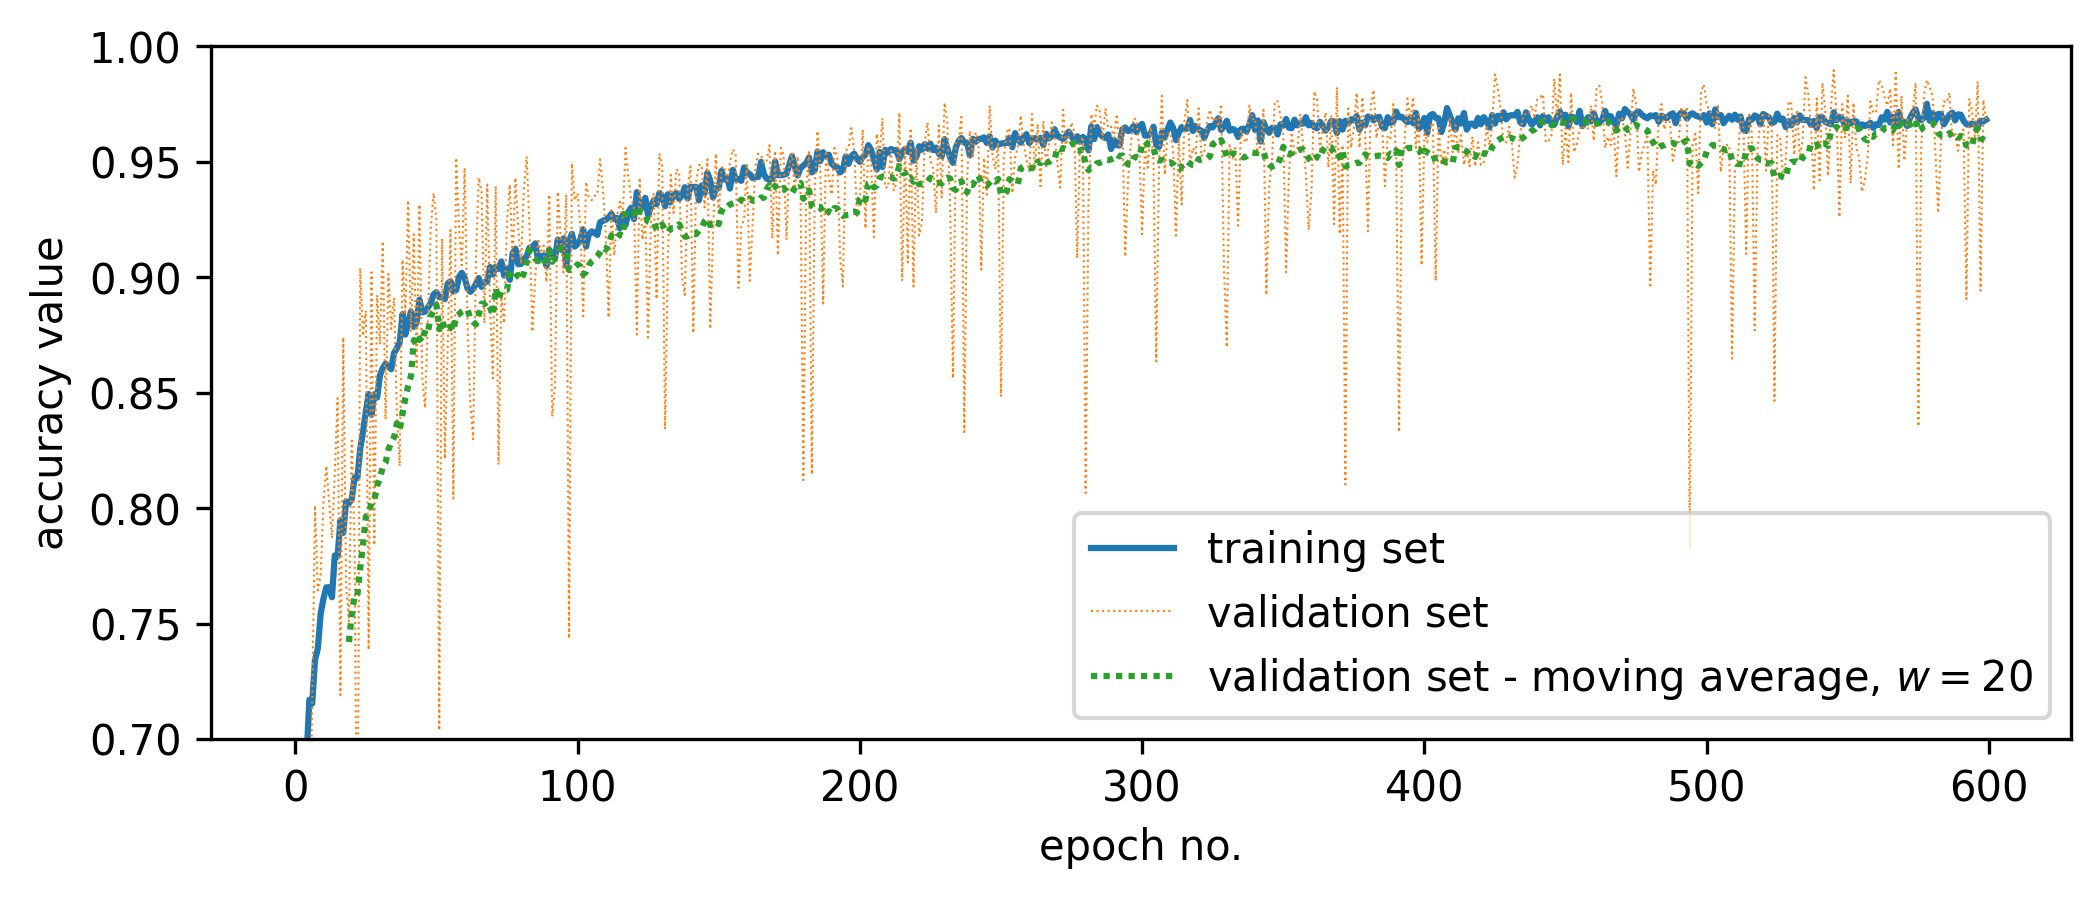

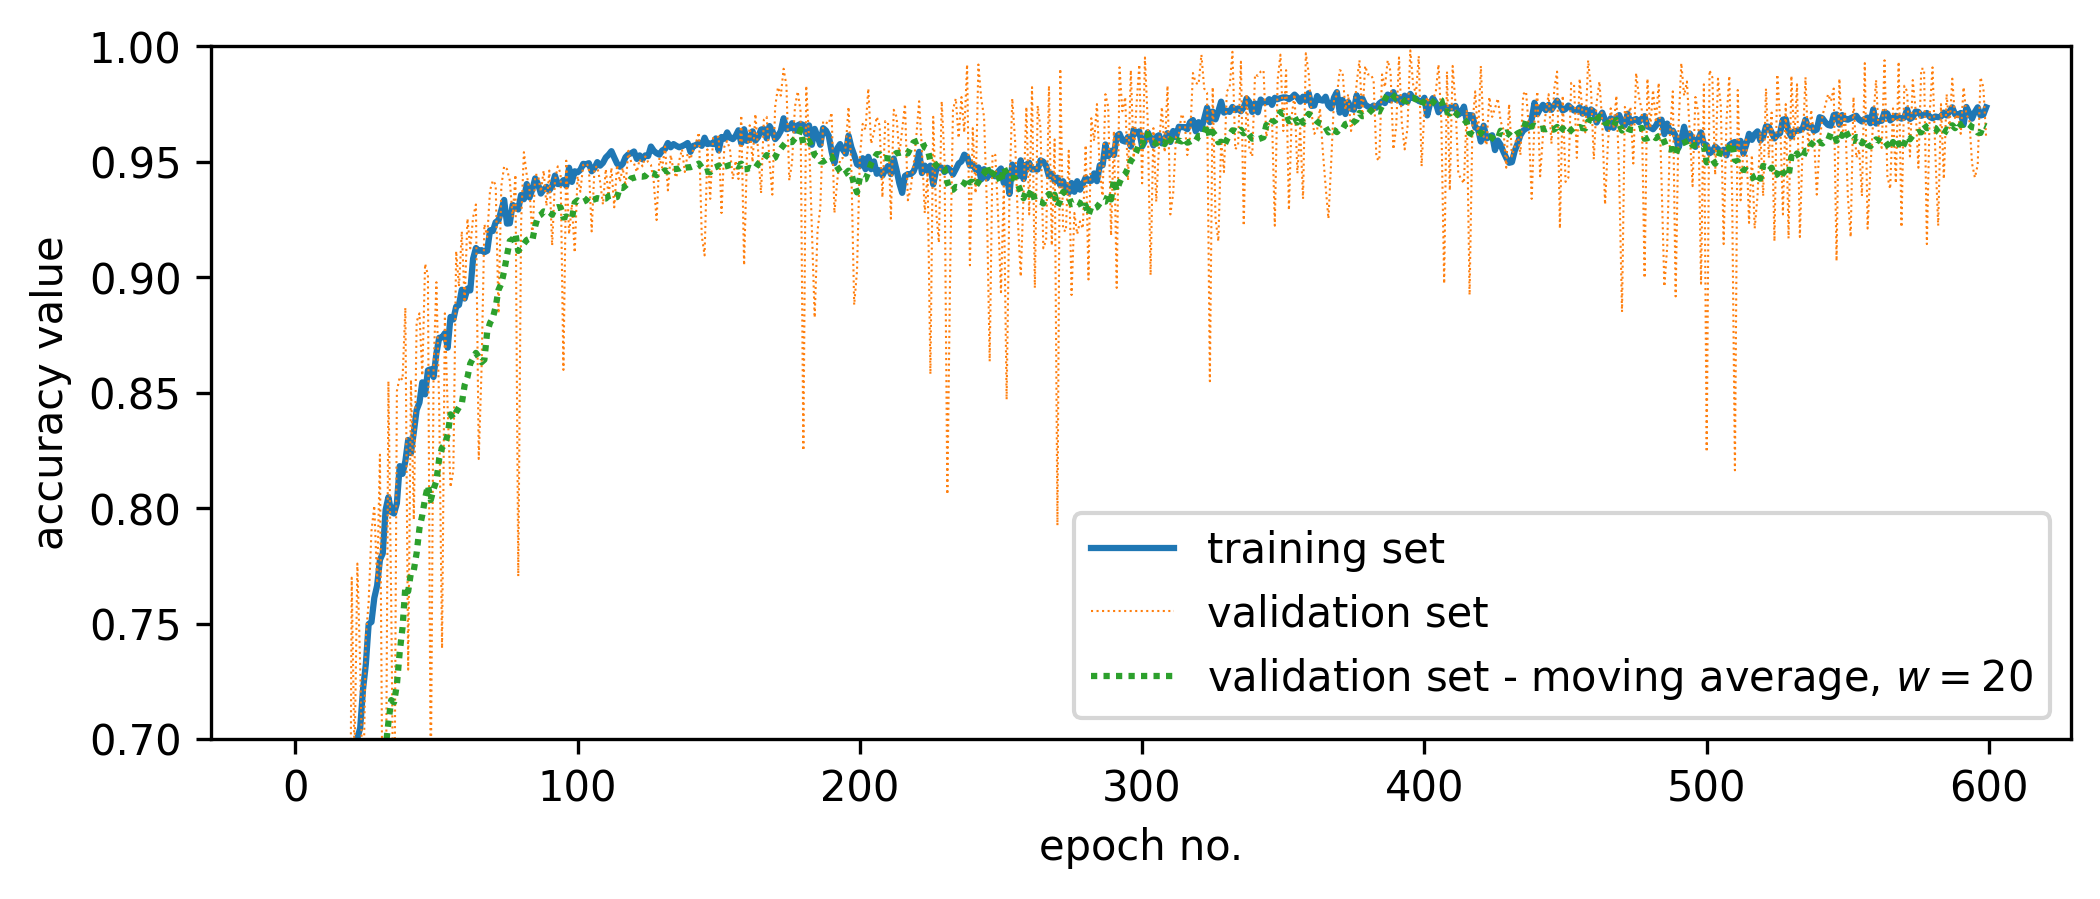

In [17]:
from common.plot import plot_metric_history_zoomed, plot_metric_history

history_df = pd.read_csv(ABS_ROOT_DIR_PATH + 'trained_models/q/3rd-search/history/' + get_history_filename(q_third_df, 0))
plot_metric_history(history_df, metric='accuracy', legend_loc = 'lower right', ylim=(0.7, 1), figsize=[8,3], dpi=300)

history_df = pd.read_csv(ABS_ROOT_DIR_PATH + 'trained_models/q/3rd-search/history/' + get_history_filename(q_third_df, 11))
plot_metric_history(history_df, metric='accuracy', legend_loc = 'lower right', ylim=(0.7, 1), figsize=[8,3], dpi=300)

# plot_metric_history_zoomed(history_df, metric='accuracy', mode='max', moving_average_window=(20,), threshold_multiplier=0.95, dpi=300, legend_loc = 'lower right', subplots=2)

## phi

### v1

In [18]:
hp_df_transform(pd.read_csv(ABS_ROOT_DIR_PATH + 'trained_models/phi/first/hp.csv'), metric='loss', ascending=True)
# print(hp_df.to_latex(index=False))

,topologia sieci,funkcja aktywacji,max(train),med(test),std(test)
1,3x1x32,pol\_sigmoid,0.005031,0.004447,0.001784
6,3x1x64,pol\_sigmoid,0.005271,0.005019,0.002429
20,3x2x32,pol\_tanh,0.005842,0.005190,0.002229
10,3x1x96,pol\_tanh,0.005154,0.005240,0.001499
30,3x2x96,pol\_tanh,0.005652,0.005262,0.002339
...,...,...,...,...,...
163,10x3x32,cart\_sigmoid,0.027048,0.029668,0.002541
143,10x2x32,cart\_sigmoid,0.028502,0.030368,0.001065
122,10x1x32,cart\_tanh,0.033277,0.032618,0.000933
162,10x3x32,cart\_tanh,0.032770,0.033443,0.001447


In [19]:
phi_first_df = construct_df_from_history_files(ABS_ROOT_DIR_PATH + 'trained_models/phi/1st-search/history/', metric='loss')
phi_first_df.sort_values('med(test)', ascending=True)[:MAX_ROWS]

,liczba punktów,liczba warstw,liczba neuronów,funkcja aktywacji,warstwa wyjściowa,med(train),med(test),std(test)
39,3,2,16,pol_sigmoid,convert_to_real_with_angle,0.005153,0.005333,0.000822
6,3,1,16,pol_sigmoid,convert_to_real_with_angle,0.005153,0.005621,0.000131
14,3,3,64,pol_tanh,convert_to_real_with_angle,0.005817,0.005708,0.001082
47,3,1,64,pol_sigmoid,convert_to_real_with_angle,0.005430,0.005744,0.000262
52,3,1,64,pol_tanh,convert_to_real_with_angle,0.005525,0.005751,0.000197
1,3,1,16,pol_tanh,convert_to_real_with_angle,0.005260,0.005863,0.000334
27,3,3,64,pol_sigmoid,convert_to_real_with_angle,0.005896,0.005994,0.001762
31,3,2,64,pol_tanh,convert_to_real_with_angle,0.005885,0.006094,0.000457
15,3,3,16,pol_sigmoid,convert_to_real_with_angle,0.005854,0.006134,0.000822
3,3,2,16,pol_tanh,convert_to_real_with_angle,0.005872,0.006192,0.000867


In [20]:
print(prepare_df_to_latex(phi_first_df, ascending=True).to_latex(index=False))

\begin{tabular}{lllrrr}
\toprule
topologia sieci & funkcja aktywacji & warstwa wyjściowa & med(train) & med(test) & std(test) \\
\midrule
3-2x16 & pol_sigmoid & convert_to_real_with_angle & 0.005153 & 0.005333 & 0.000822 \\
3-1x16 & pol_sigmoid & convert_to_real_with_angle & 0.005153 & 0.005621 & 0.000131 \\
3-3x64 & pol_tanh & convert_to_real_with_angle & 0.005817 & 0.005708 & 0.001082 \\
3-1x64 & pol_sigmoid & convert_to_real_with_angle & 0.005430 & 0.005744 & 0.000262 \\
3-1x64 & pol_tanh & convert_to_real_with_angle & 0.005525 & 0.005751 & 0.000197 \\
3-1x16 & pol_tanh & convert_to_real_with_angle & 0.005260 & 0.005863 & 0.000334 \\
3-3x64 & pol_sigmoid & convert_to_real_with_angle & 0.005896 & 0.005994 & 0.001762 \\
3-2x64 & pol_tanh & convert_to_real_with_angle & 0.005885 & 0.006094 & 0.000457 \\
3-3x16 & pol_sigmoid & convert_to_real_with_angle & 0.005854 & 0.006134 & 0.000822 \\
3-2x16 & pol_tanh & convert_to_real_with_angle & 0.005872 & 0.006192 & 0.000867 \\
3-3x16 & pol_tanh

In [21]:
phi_second_df = construct_df_from_history_files(ABS_ROOT_DIR_PATH + 'trained_models/phi/2nd-search/history/', metric='loss')
phi_second_df.sort_values('med(train)', ascending=True)

,liczba punktów,liczba warstw,liczba neuronów,funkcja aktywacji,warstwa wyjściowa,med(train),med(test),std(test)
1,3,2,16,pol_tanh,convert_to_real_with_angle,0.004739,0.005025,0.001047
20,3,2,64,pol_sigmoid,convert_to_real_with_angle,0.004921,0.005372,0.001105
19,3,2,128,pol_tanh,convert_to_real_with_angle,0.005067,0.005481,0.000496
17,3,1,32,pol_tanh,convert_to_real_with_angle,0.005140,0.005588,0.000371
14,3,2,64,pol_tanh,convert_to_real_with_angle,0.005256,0.005637,0.001005
...,...,...,...,...,...,...,...,...
9,3,3,32,pol_sigmoid,convert_to_real_with_angle,0.005528,0.006463,0.001955
13,3,2,32,pol_tanh,convert_to_real_with_angle,0.005541,0.005849,0.000573
6,3,3,16,pol_sigmoid,convert_to_real_with_angle,0.005555,0.006073,0.001977
0,3,1,16,pol_tanh,convert_to_real_with_angle,0.005563,0.005646,0.000140


In [22]:
print(prepare_df_to_latex(phi_second_df, ascending=True).to_latex(index=False))

\begin{tabular}{lllrrr}
\toprule
topologia sieci & funkcja aktywacji & warstwa wyjściowa & med(train) & med(test) & std(test) \\
\midrule
3-2x16 & pol_tanh & convert_to_real_with_angle & 0.004739 & 0.005025 & 0.001047 \\
3-2x64 & pol_sigmoid & convert_to_real_with_angle & 0.004921 & 0.005372 & 0.001105 \\
3-2x32 & pol_sigmoid & convert_to_real_with_angle & 0.005307 & 0.005458 & 0.000586 \\
3-2x128 & pol_tanh & convert_to_real_with_angle & 0.005067 & 0.005481 & 0.000496 \\
3-3x32 & pol_tanh & convert_to_real_with_angle & 0.005522 & 0.005528 & 0.000551 \\
3-3x64 & pol_sigmoid & convert_to_real_with_angle & 0.005426 & 0.005550 & 0.001498 \\
3-1x64 & pol_tanh & convert_to_real_with_angle & 0.005292 & 0.005557 & 0.000354 \\
3-1x32 & pol_tanh & convert_to_real_with_angle & 0.005140 & 0.005588 & 0.000371 \\
3-2x16 & pol_sigmoid & convert_to_real_with_angle & 0.005413 & 0.005631 & 0.000337 \\
3-2x64 & pol_tanh & convert_to_real_with_angle & 0.005256 & 0.005637 & 0.001005 \\
3-1x16 & pol_tanh &

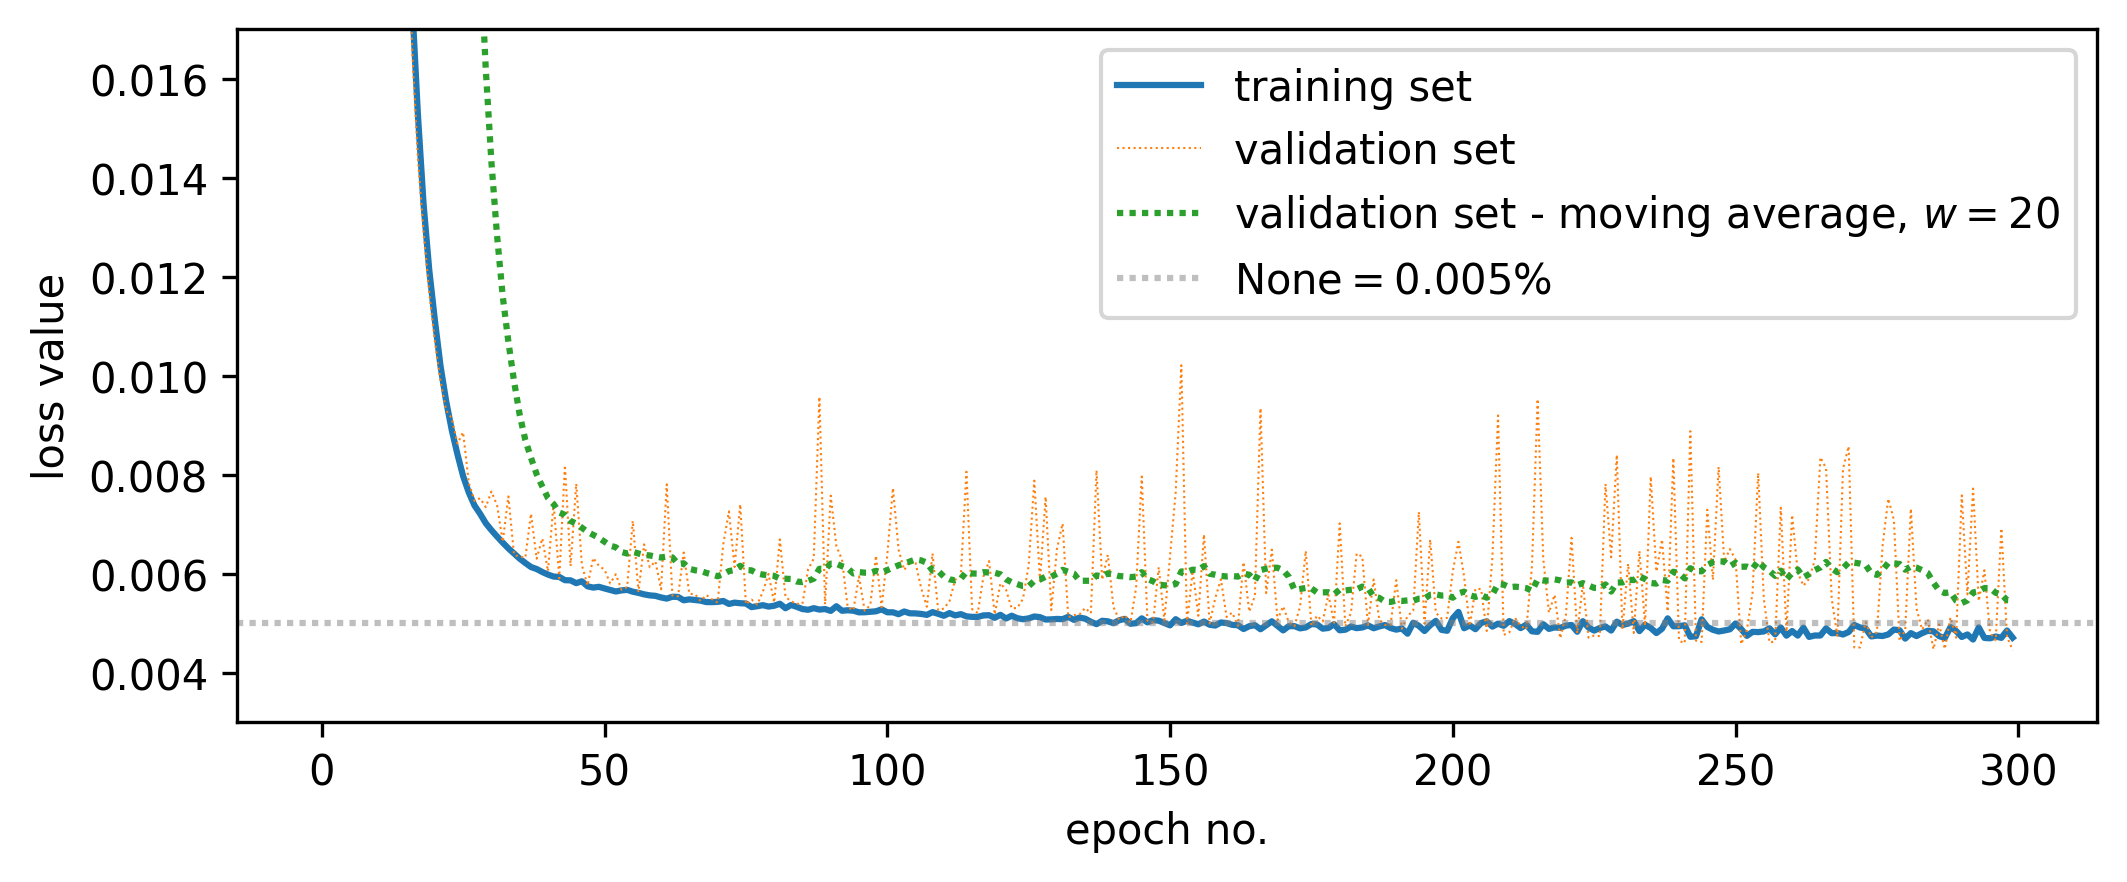

In [23]:
history_df = pd.read_csv(ABS_ROOT_DIR_PATH + 'trained_models/phi/2nd-search/history/' + get_history_filename(phi_second_df, 1))
from common.plot import plot_metric_history
plot_metric_history(history_df, metric = 'loss', legend_loc = 'upper right', ylim=(0.003,0.017), dpi=300, figsize=[8,3], hline=0.005)

In [24]:
# 3rd-search
phi_third_df = construct_df_from_history_files(ABS_ROOT_DIR_PATH + 'trained_models/phi/3rd-search/history/', metric='loss')
phi_third_df.sort_values('med(test)', ascending=True)

,liczba punktów,liczba warstw,liczba neuronów,funkcja aktywacji,warstwa wyjściowa,med(train),med(test),std(test)
1,3,1,8,pol_tanh,convert_to_real_with_angle,0.005014,0.005086,0.000483
20,3,1,4,pol_sigmoid,convert_to_real_with_angle,0.005240,0.005282,0.000111
17,3,4,12,pol_tanh,convert_to_real_with_angle,0.006071,0.005321,0.001701
2,3,2,12,pol_tanh,convert_to_real_with_angle,0.004912,0.005329,0.001314
18,3,1,12,pol_sigmoid,convert_to_real_with_angle,0.005019,0.005453,0.000524
...,...,...,...,...,...,...,...,...
19,3,3,4,pol_sigmoid,convert_to_real_with_angle,0.005771,0.006646,0.001598
14,3,4,12,pol_sigmoid,convert_to_real_with_angle,0.006370,0.006663,0.001808
12,3,3,4,pol_tanh,convert_to_real_with_angle,0.006005,0.006802,0.002572
3,3,4,8,pol_tanh,convert_to_real_with_angle,0.006357,0.007426,0.002357


In [25]:
print(prepare_df_to_latex(phi_third_df, ascending=True).to_latex(index=False))

\begin{tabular}{lllrrr}
\toprule
topologia sieci & funkcja aktywacji & warstwa wyjściowa & med(train) & med(test) & std(test) \\
\midrule
3-1x8 & pol_tanh & convert_to_real_with_angle & 0.005014 & 0.005086 & 0.000483 \\
3-1x4 & pol_sigmoid & convert_to_real_with_angle & 0.005240 & 0.005282 & 0.000111 \\
3-4x12 & pol_tanh & convert_to_real_with_angle & 0.006071 & 0.005321 & 0.001701 \\
3-2x12 & pol_tanh & convert_to_real_with_angle & 0.004912 & 0.005329 & 0.001314 \\
3-1x12 & pol_sigmoid & convert_to_real_with_angle & 0.005019 & 0.005453 & 0.000524 \\
3-1x8 & pol_sigmoid & convert_to_real_with_angle & 0.005435 & 0.005564 & 0.000160 \\
3-2x8 & pol_tanh & convert_to_real_with_angle & 0.005029 & 0.005623 & 0.000745 \\
3-3x12 & pol_tanh & convert_to_real_with_angle & 0.005659 & 0.005693 & 0.002594 \\
3-1x12 & pol_tanh & convert_to_real_with_angle & 0.005078 & 0.005863 & 0.000784 \\
3-1x4 & pol_tanh & convert_to_real_with_angle & 0.005892 & 0.005965 & 0.000364 \\
3-2x4 & pol_tanh & convert_t

In [26]:
df['|med(train)-med(test)|'] = np.abs(df['med(train)']-df['med(test)'])
df.sort_values('|med(train)-med(test)|', ascending=True)[:MAX_ROWS]

,liczba punktów,liczba warstw,liczba neuronów,funkcja aktywacji,warstwa wyjściowa,med(train),med(test),std(test),|med(train)-med(test)|
8,10,2,64,pol_tanh,softmax_real_with_mult,0.932823,0.932987,0.024736,0.000163
21,10,3,16,pol_tanh,softmax_real_with_abs,0.956542,0.956242,0.028024,0.000299
16,10,3,16,pol_sigmoid,softmax_real_with_abs,0.954782,0.953794,0.019233,0.000988
58,10,2,16,pol_sigmoid,softmax_real_with_abs,0.947054,0.945532,0.021760,0.001522
37,10,3,16,pol_sigmoid,softmax_real_with_mult,0.929992,0.931763,0.051235,0.001770
53,10,3,64,pol_sigmoid,softmax_real_with_polar,0.903366,0.905141,0.034981,0.001774
14,10,2,16,pol_sigmoid,softmax_real_with_polar,0.886534,0.888311,0.038179,0.001777
51,10,3,16,cart_sigmoid,softmax_real_with_abs,0.695792,0.698286,0.026689,0.002495
56,10,3,16,pol_tanh,softmax_real_with_polar,0.899694,0.896879,0.051454,0.002815
33,10,3,64,pol_sigmoid,softmax_real_with_avg,0.936266,0.932681,0.057786,0.003586


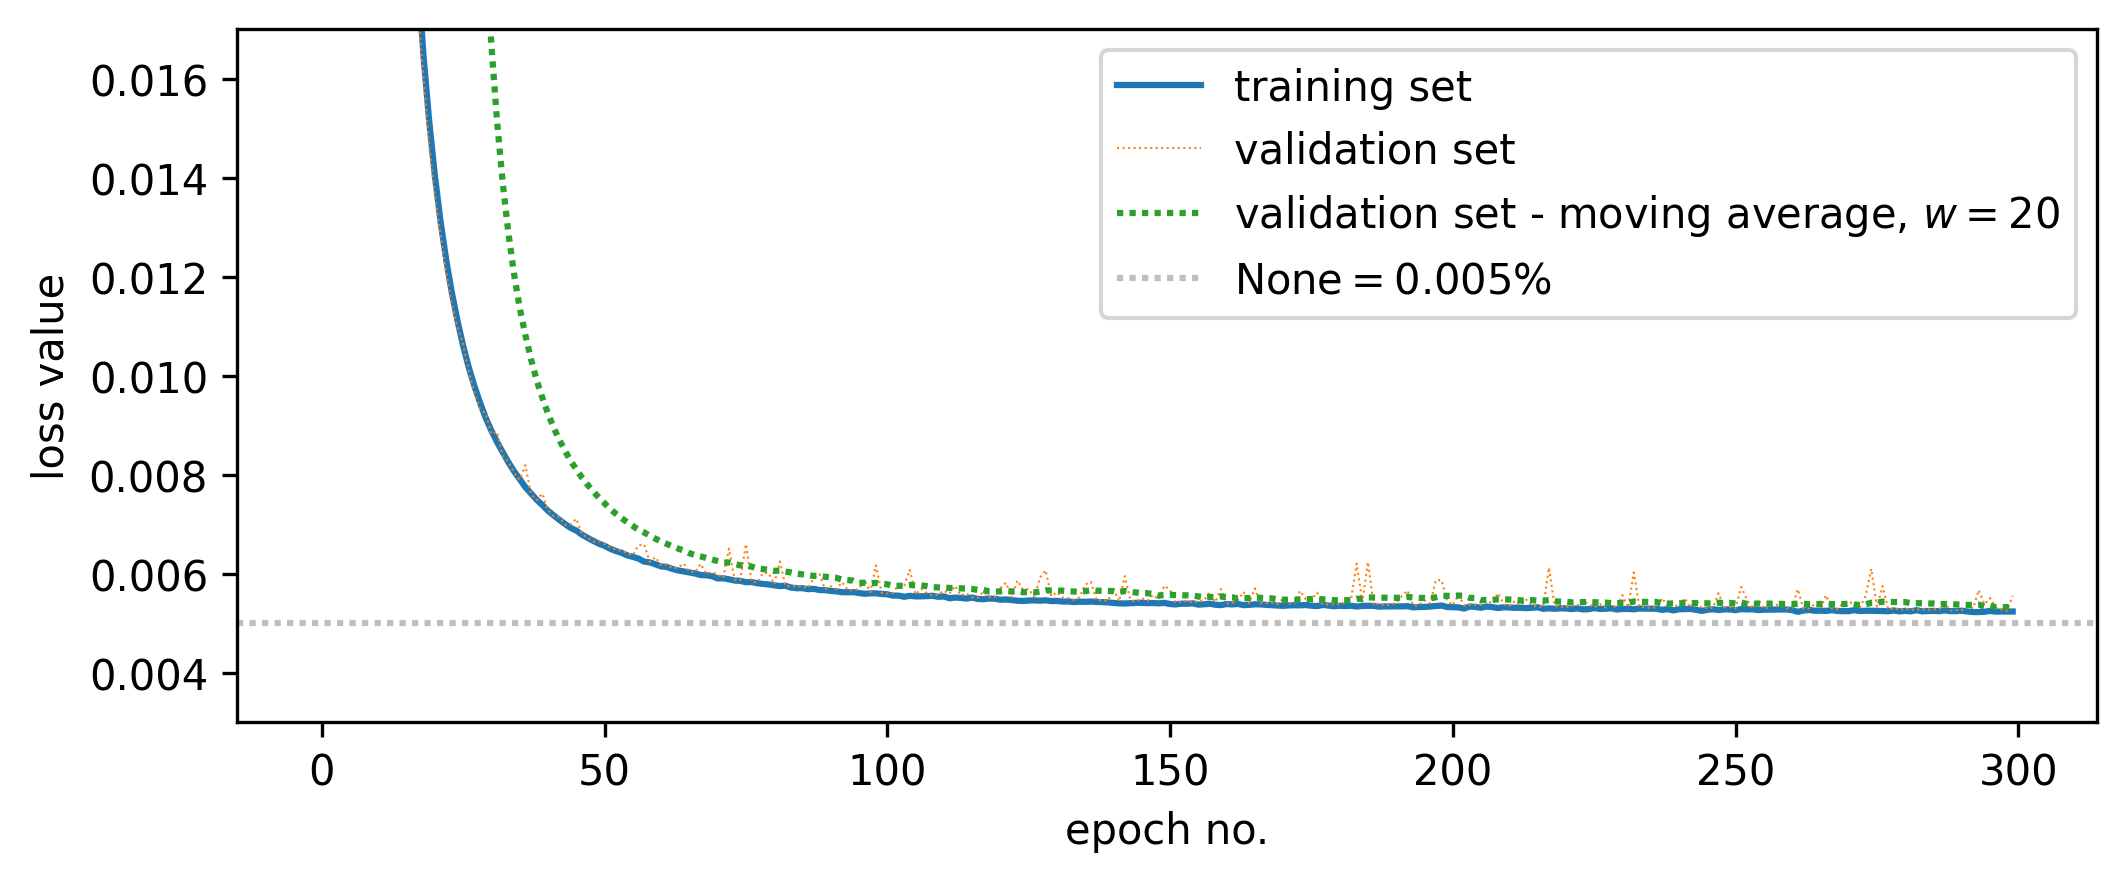

In [27]:
history_df = pd.read_csv(ABS_ROOT_DIR_PATH + 'trained_models/phi/3rd-search/history/' + get_history_filename(phi_third_df, 20))
from common.plot import plot_metric_history
plot_metric_history(history_df, metric = 'loss', legend_loc = 'upper right', ylim=(0.003,0.017), dpi=300, figsize=[8,3], hline=0.005)

### v2

In [28]:
phi_first_df = construct_df_from_history_files(ABS_ROOT_DIR_PATH + 'trained_models/phi/1st-search-v2/history/', metric='loss')
phi_first_df.sort_values('med(test)', ascending=True)[:MAX_ROWS]

,liczba punktów,liczba warstw,liczba neuronów,funkcja aktywacji,warstwa wyjściowa,med(train),med(test),std(test)
46,3,1,64,pol_sigmoid,convert_to_real_with_angle,0.005399,0.004982,0.001889
1,3,1,16,pol_tanh,convert_to_real_with_angle,0.005390,0.005321,0.001223
14,3,3,64,pol_tanh,convert_to_real_with_angle,0.006340,0.005665,0.002751
6,3,1,16,pol_sigmoid,convert_to_real_with_angle,0.005728,0.005887,0.001527
51,3,1,64,pol_tanh,convert_to_real_with_angle,0.005637,0.006141,0.002030
47,3,2,64,pol_sigmoid,convert_to_real_with_angle,0.005888,0.006224,0.001863
33,3,1,64,cart_relu,convert_to_real_with_angle,0.005659,0.006230,0.001114
30,3,2,64,pol_tanh,convert_to_real_with_angle,0.005920,0.006268,0.001503
26,3,3,64,pol_sigmoid,convert_to_real_with_angle,0.006349,0.006535,0.001912
9,3,1,16,cart_relu,convert_to_real_with_angle,0.005953,0.006750,0.000504


In [29]:
phi_second_df = construct_df_from_history_files(ABS_ROOT_DIR_PATH + 'trained_models/phi/2nd-search-v2/history/', metric='loss')
phi_second_df.sort_values('med(test)', ascending=True)[:MAX_ROWS]

,liczba punktów,liczba warstw,liczba neuronów,funkcja aktywacji,warstwa wyjściowa,med(train),med(test),std(test)
0,3,1,16,pol_tanh,convert_to_real_with_angle,0.005168,0.005016,0.001683
18,3,1,64,pol_sigmoid,convert_to_real_with_angle,0.004968,0.005071,0.001890
17,3,1,32,pol_tanh,convert_to_real_with_angle,0.004870,0.005362,0.001934
14,3,2,64,pol_tanh,convert_to_real_with_angle,0.005450,0.005404,0.002093
13,3,2,32,pol_tanh,convert_to_real_with_angle,0.005562,0.005533,0.001822
8,3,3,16,pol_tanh,convert_to_real_with_angle,0.006233,0.005617,0.001638
7,3,2,32,pol_sigmoid,convert_to_real_with_angle,0.005274,0.005639,0.002569
4,3,3,32,pol_tanh,convert_to_real_with_angle,0.005843,0.005745,0.001501
22,3,1,128,pol_tanh,convert_to_real_with_angle,0.005113,0.005780,0.001858
21,3,1,128,pol_sigmoid,convert_to_real_with_angle,0.004893,0.005822,0.001563


In [30]:
phi_third_df = construct_df_from_history_files(ABS_ROOT_DIR_PATH + 'trained_models/phi/3rd-search-v2/history/', metric='loss')
phi_third_df.sort_values('med(test)', ascending=True)[:MAX_ROWS]

,liczba punktów,liczba warstw,liczba neuronów,funkcja aktywacji,warstwa wyjściowa,med(train),med(test),std(test)
9,3,1,4,pol_tanh,convert_to_real_with_angle,0.005135,0.005145,0.001757
18,3,1,12,pol_sigmoid,convert_to_real_with_angle,0.005248,0.005219,0.001561
11,3,3,8,pol_tanh,convert_to_real_with_angle,0.005525,0.005536,0.001746
7,3,2,4,pol_tanh,convert_to_real_with_angle,0.005346,0.005543,0.001450
21,3,1,8,pol_sigmoid,convert_to_real_with_angle,0.005371,0.005553,0.001700
8,3,3,8,pol_sigmoid,convert_to_real_with_angle,0.005916,0.005592,0.001291
14,3,4,12,pol_sigmoid,convert_to_real_with_angle,0.006198,0.005688,0.002437
17,3,4,12,pol_tanh,convert_to_real_with_angle,0.006654,0.005744,0.003049
13,3,2,8,pol_tanh,convert_to_real_with_angle,0.005678,0.005753,0.002171
10,3,2,8,pol_sigmoid,convert_to_real_with_angle,0.005932,0.005835,0.001569


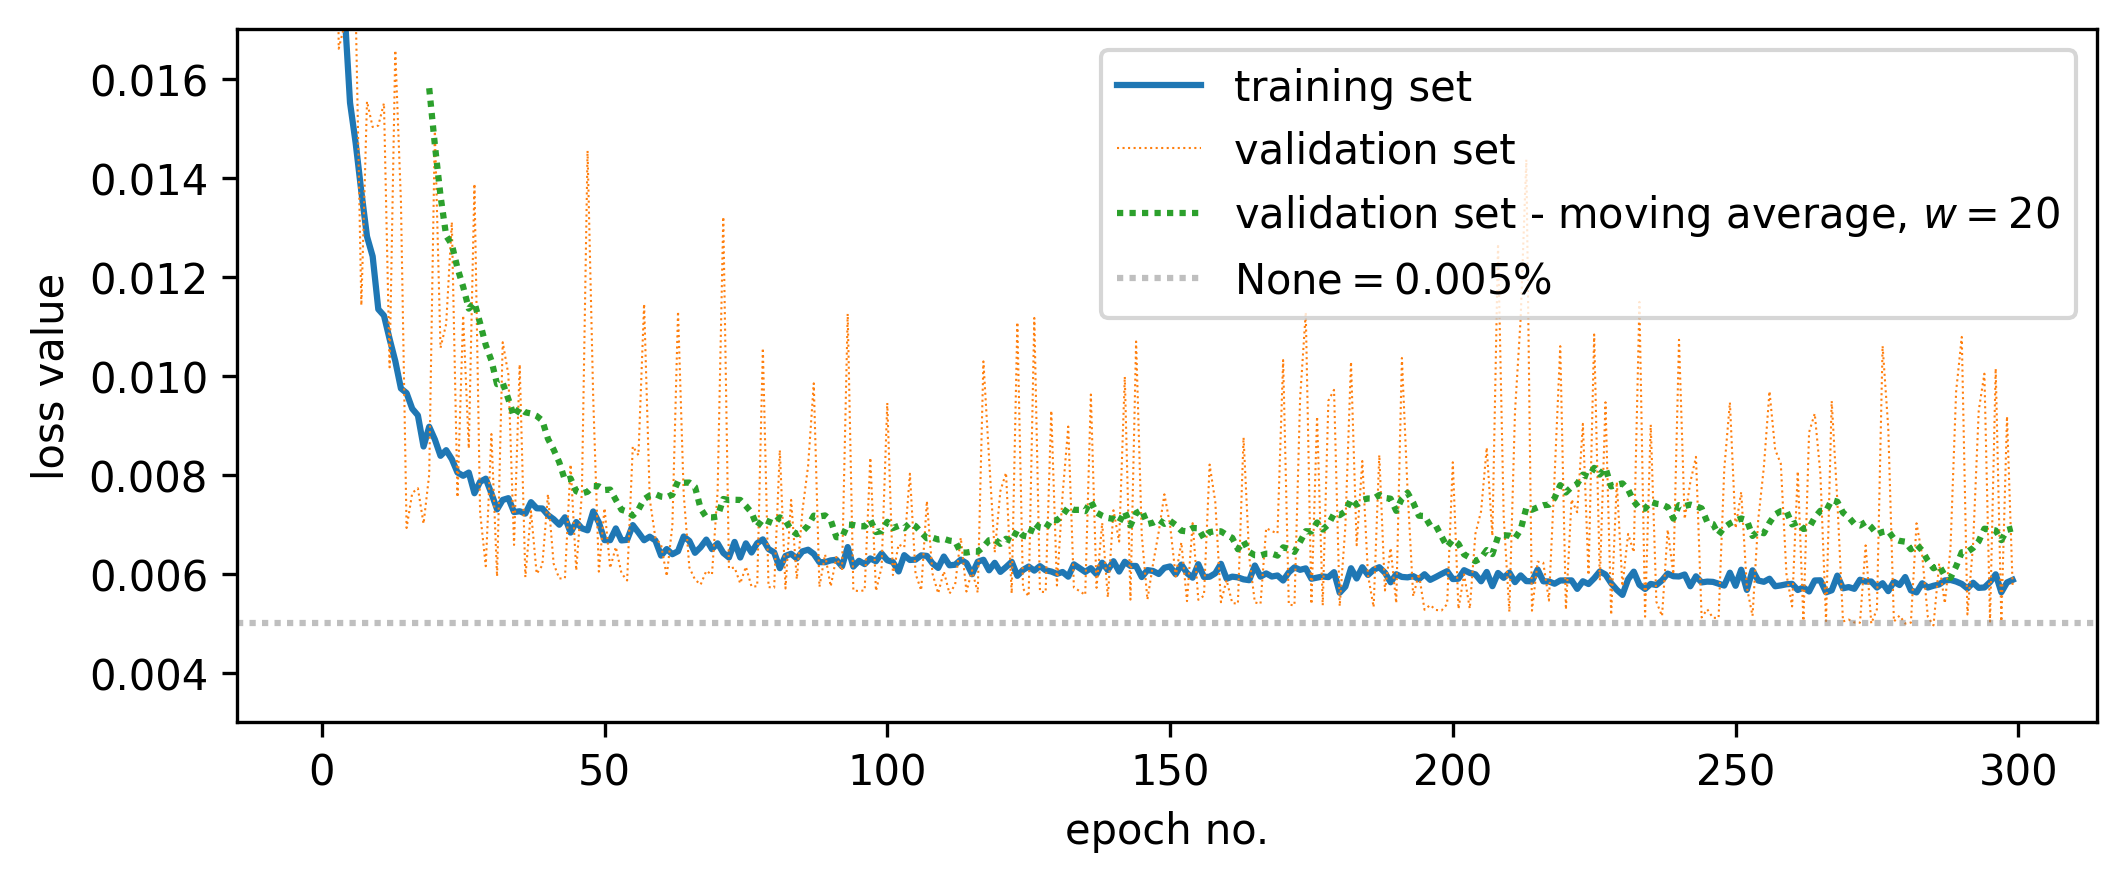

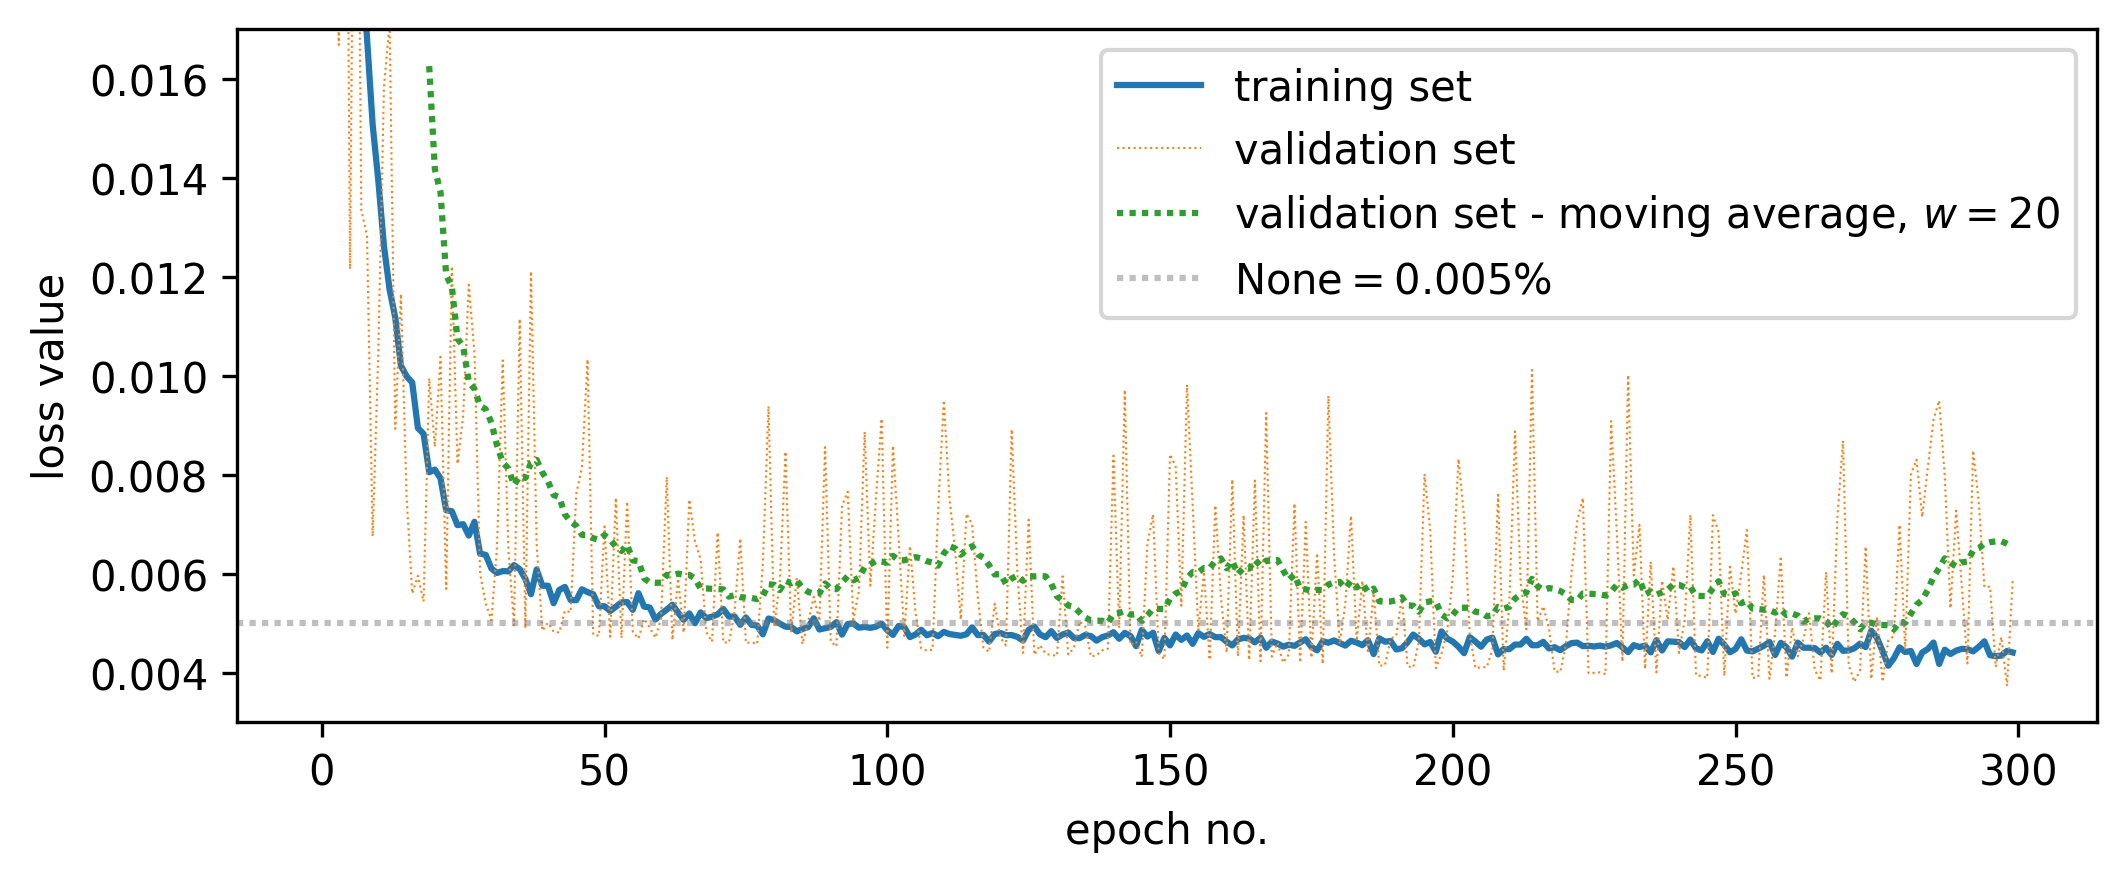

In [31]:
history_df = pd.read_csv(ABS_ROOT_DIR_PATH + 'trained_models/phi/2nd-search-v2/history/' + get_history_filename(phi_second_df, 1))
from common.plot import plot_metric_history
plot_metric_history(history_df, metric = 'loss', legend_loc = 'upper right', ylim=(0.003,0.017), dpi=300, figsize=[8,3], hline=0.005)

history_df = pd.read_csv(ABS_ROOT_DIR_PATH + 'trained_models/phi/3rd-search-v2/history/' + get_history_filename(phi_third_df, 20))
from common.plot import plot_metric_history
plot_metric_history(history_df, metric = 'loss', legend_loc = 'upper right', ylim=(0.003,0.017), dpi=300, figsize=[8,3], hline=0.005)

## pt

In [32]:
pt_first_df = construct_df_from_history_files(ABS_ROOT_DIR_PATH + 'trained_models/pt/1st-search-v2/history/', metric='mean_absolute_percentage_error')
pt_first_df.sort_values('med(test)', ascending=True)

,liczba punktów,liczba warstw,liczba neuronów,funkcja aktywacji,warstwa wyjściowa,med(train),med(test),std(test)
2,10,3,128,pol_sigmoid,convert_to_real_with_abs,29.153389,28.745491,3.196543
15,10,3,128,pol_tanh,convert_to_real_with_abs,28.867465,28.765767,4.018557
6,10,3,16,pol_sigmoid,convert_to_real_with_abs,31.711597,32.168523,3.829578
17,10,3,16,pol_tanh,convert_to_real_with_abs,33.908295,33.761370,3.289961
10,10,3,128,cart_relu,convert_to_real_with_abs,33.253267,45.606201,1.821666
16,3,3,128,pol_sigmoid,convert_to_real_with_abs,67.062603,66.956493,5.192575
13,10,3,128,cart_tanh,convert_to_real_with_abs,65.901852,66.968620,3.996900
11,10,3,16,cart_sigmoid,convert_to_real_with_abs,66.859749,67.478188,1.306817
19,3,3,128,cart_sigmoid,convert_to_real_with_abs,66.535427,67.504200,2.479035
8,3,3,16,pol_sigmoid,convert_to_real_with_abs,67.029289,67.586395,1.474973


In [38]:
print(prepare_df_to_latex(pt_first_df, ascending=True).to_latex(index=False, float_format="{:.2f}%".format))

\begin{tabular}{lllrrr}
\toprule
topologia sieci & funkcja aktywacji & warstwa wyjściowa & med(train) & med(test) & std(test) \\
\midrule
10-3x128 & pol_sigmoid & convert_to_real_with_abs & 29.15% & 28.75% & 3.20% \\
10-3x128 & pol_tanh & convert_to_real_with_abs & 28.87% & 28.77% & 4.02% \\
10-3x16 & pol_sigmoid & convert_to_real_with_abs & 31.71% & 32.17% & 3.83% \\
10-3x16 & pol_tanh & convert_to_real_with_abs & 33.91% & 33.76% & 3.29% \\
10-3x128 & cart_relu & convert_to_real_with_abs & 33.25% & 45.61% & 1.82% \\
3-3x128 & pol_sigmoid & convert_to_real_with_abs & 67.06% & 66.96% & 5.19% \\
10-3x128 & cart_tanh & convert_to_real_with_abs & 65.90% & 66.97% & 4.00% \\
10-3x16 & cart_sigmoid & convert_to_real_with_abs & 66.86% & 67.48% & 1.31% \\
3-3x128 & cart_sigmoid & convert_to_real_with_abs & 66.54% & 67.50% & 2.48% \\
3-3x16 & pol_sigmoid & convert_to_real_with_abs & 67.03% & 67.59% & 1.47% \\
3-3x16 & pol_tanh & convert_to_real_with_abs & 67.10% & 67.85% & 1.42% \\
10-3x16 & car

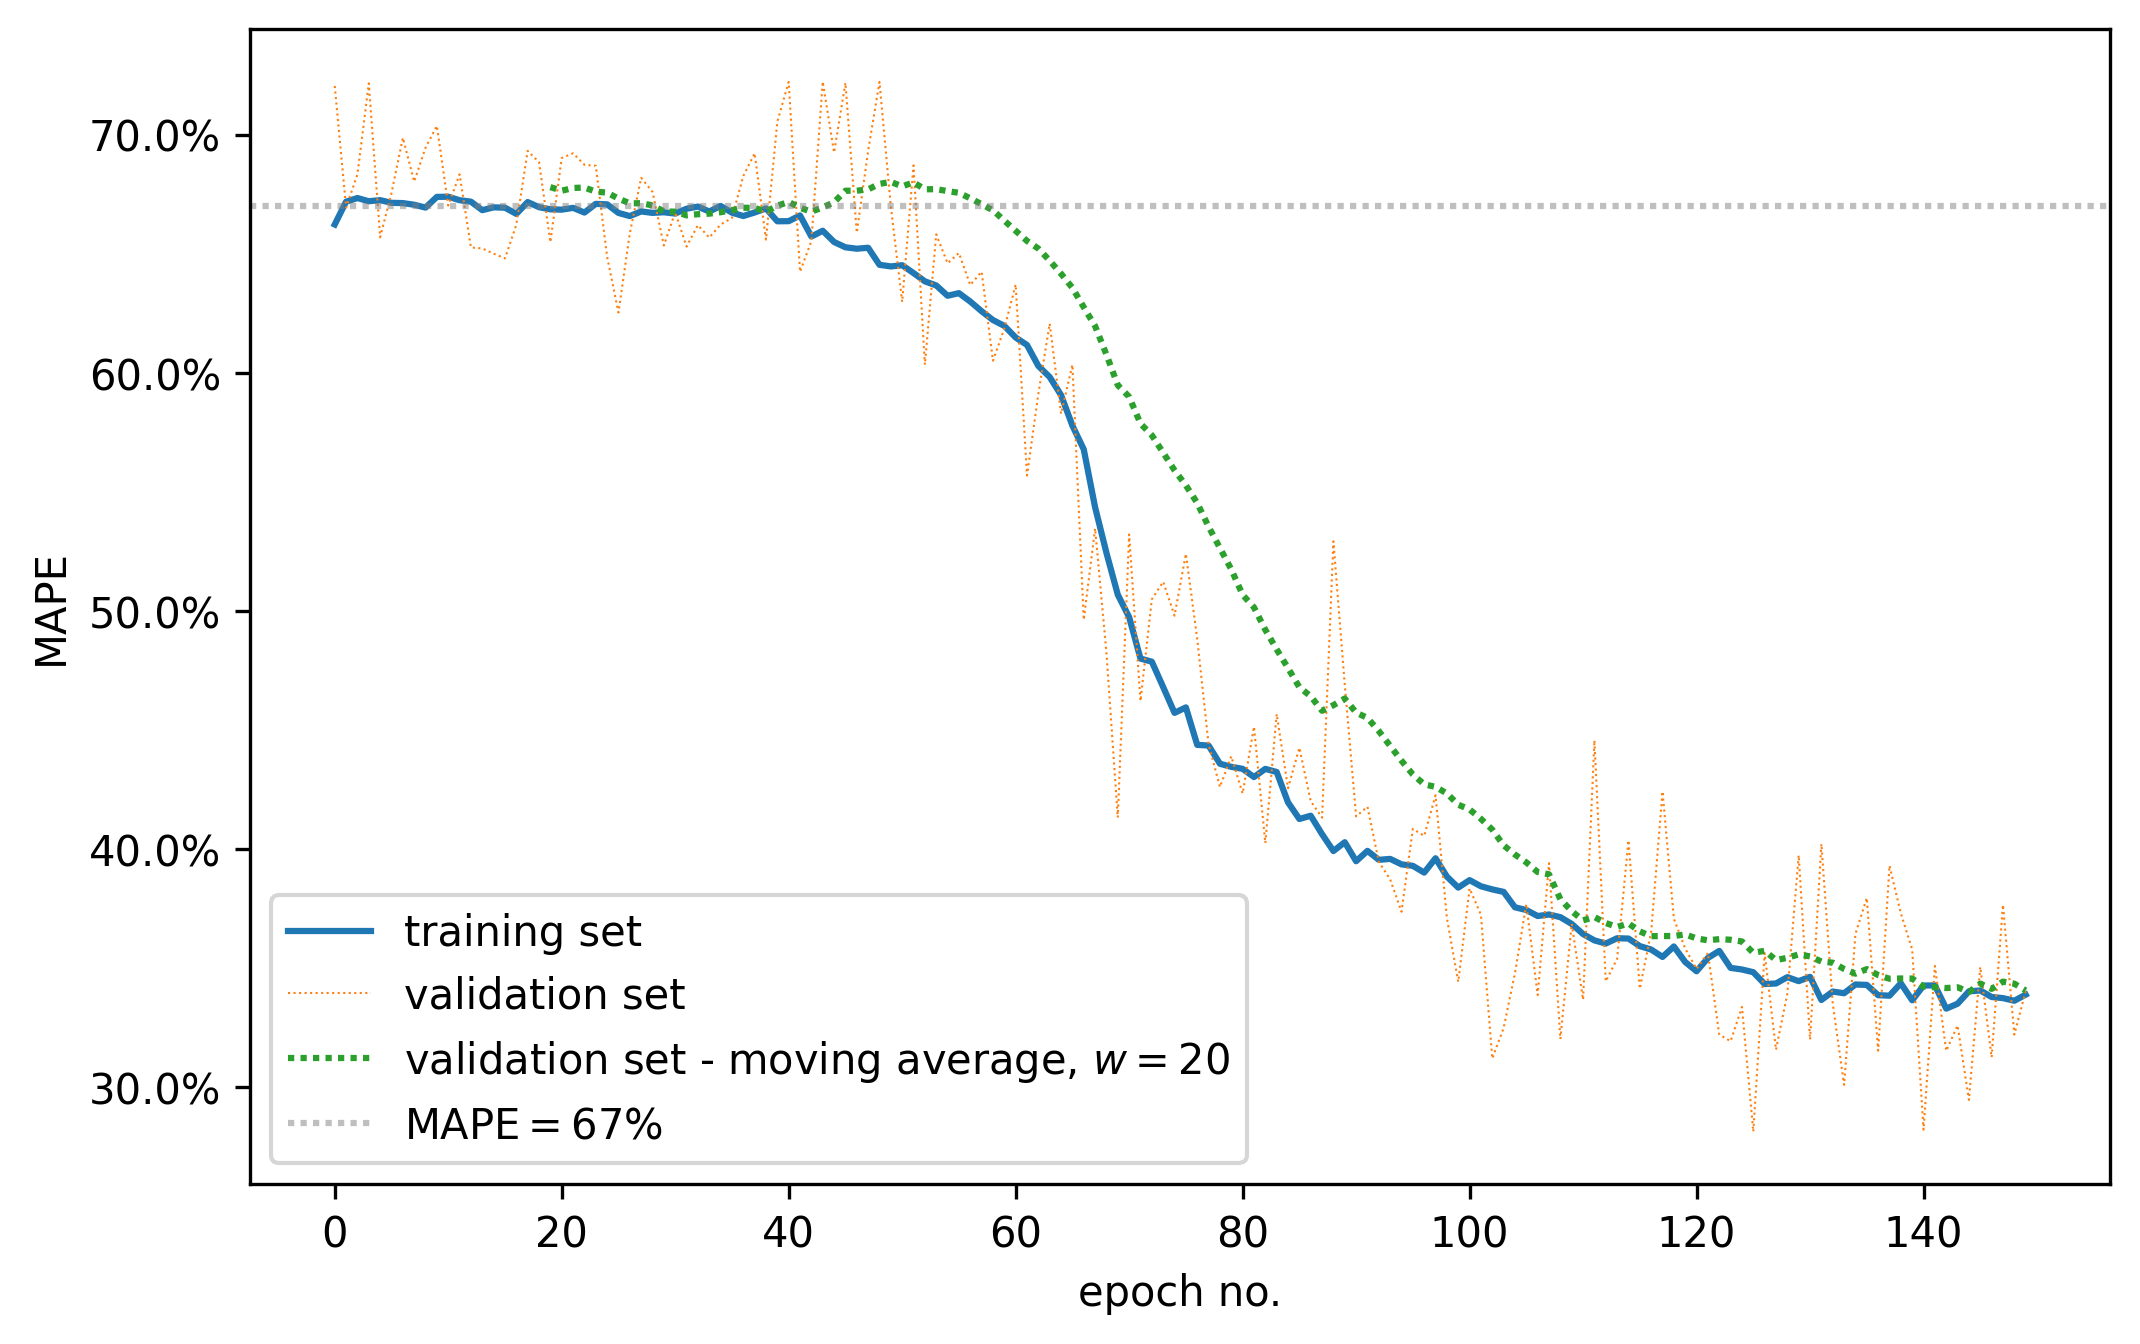

In [33]:
history_df = pd.read_csv(ABS_ROOT_DIR_PATH + 'trained_models/pt/1st-search-v2/history/' + get_history_filename(pt_first_df, 17))
from common.plot import plot_metric_history
import matplotlib.ticker as tick
plot_metric_history(history_df, metric = 'mean_absolute_percentage_error', legend_loc = 'lower left', dpi=300, figsize=[8,5], y_label='MAPE', y_formatter=tick.PercentFormatter(), hline=67)

In [34]:
pt_second_df = construct_df_from_history_files(ABS_ROOT_DIR_PATH + 'trained_models/pt/2nd-search-v2/history/', metric='mean_absolute_percentage_error')
pt_second_df.sort_values('med(test)', ascending=True)[:MAX_ROWS]

,liczba punktów,liczba warstw,liczba neuronów,funkcja aktywacji,warstwa wyjściowa,med(train),med(test),std(test)
12,10,4,16,pol_sigmoid,convert_to_real_with_abs,27.274949,24.900136,12.893651
15,10,2,16,pol_tanh,convert_to_real_with_abs,27.322046,25.219535,7.120437
7,10,3,16,pol_sigmoid,convert_to_real_with_abs,26.610962,25.398798,8.134512
2,10,4,128,pol_tanh,convert_to_real_with_abs,30.243304,26.549662,11.561913
13,10,4,16,pol_tanh,convert_to_real_with_abs,27.843486,29.155883,9.887216
22,10,3,16,pol_tanh,convert_to_real_with_abs,27.813646,29.860124,7.835027
23,10,3,8,pol_sigmoid,convert_to_real_with_abs,32.435034,30.407176,18.636594
11,10,3,8,pol_tanh,convert_to_real_with_abs,33.905251,31.622547,13.140084
16,10,2,16,pol_sigmoid,convert_to_real_with_abs,28.167128,31.666889,13.696808
19,10,2,8,pol_tanh,convert_to_real_with_abs,34.244108,31.996092,10.761369


In [39]:
print(prepare_df_to_latex(pt_second_df, ascending=True).to_latex(index=False, float_format="{:.2f}%".format))

\begin{tabular}{lllrrr}
\toprule
topologia sieci & funkcja aktywacji & warstwa wyjściowa & med(train) & med(test) & std(test) \\
\midrule
10-4x16 & pol_sigmoid & convert_to_real_with_abs & 27.27% & 24.90% & 12.89% \\
10-2x16 & pol_tanh & convert_to_real_with_abs & 27.32% & 25.22% & 7.12% \\
10-3x16 & pol_sigmoid & convert_to_real_with_abs & 26.61% & 25.40% & 8.13% \\
10-4x128 & pol_tanh & convert_to_real_with_abs & 30.24% & 26.55% & 11.56% \\
10-4x16 & pol_tanh & convert_to_real_with_abs & 27.84% & 29.16% & 9.89% \\
10-3x16 & pol_tanh & convert_to_real_with_abs & 27.81% & 29.86% & 7.84% \\
10-3x8 & pol_sigmoid & convert_to_real_with_abs & 32.44% & 30.41% & 18.64% \\
10-3x8 & pol_tanh & convert_to_real_with_abs & 33.91% & 31.62% & 13.14% \\
10-2x16 & pol_sigmoid & convert_to_real_with_abs & 28.17% & 31.67% & 13.70% \\
10-2x8 & pol_tanh & convert_to_real_with_abs & 34.24% & 32.00% & 10.76% \\
10-4x8 & pol_tanh & convert_to_real_with_abs & 33.77% & 32.02% & 12.91% \\
10-3x128 & pol_tanh &

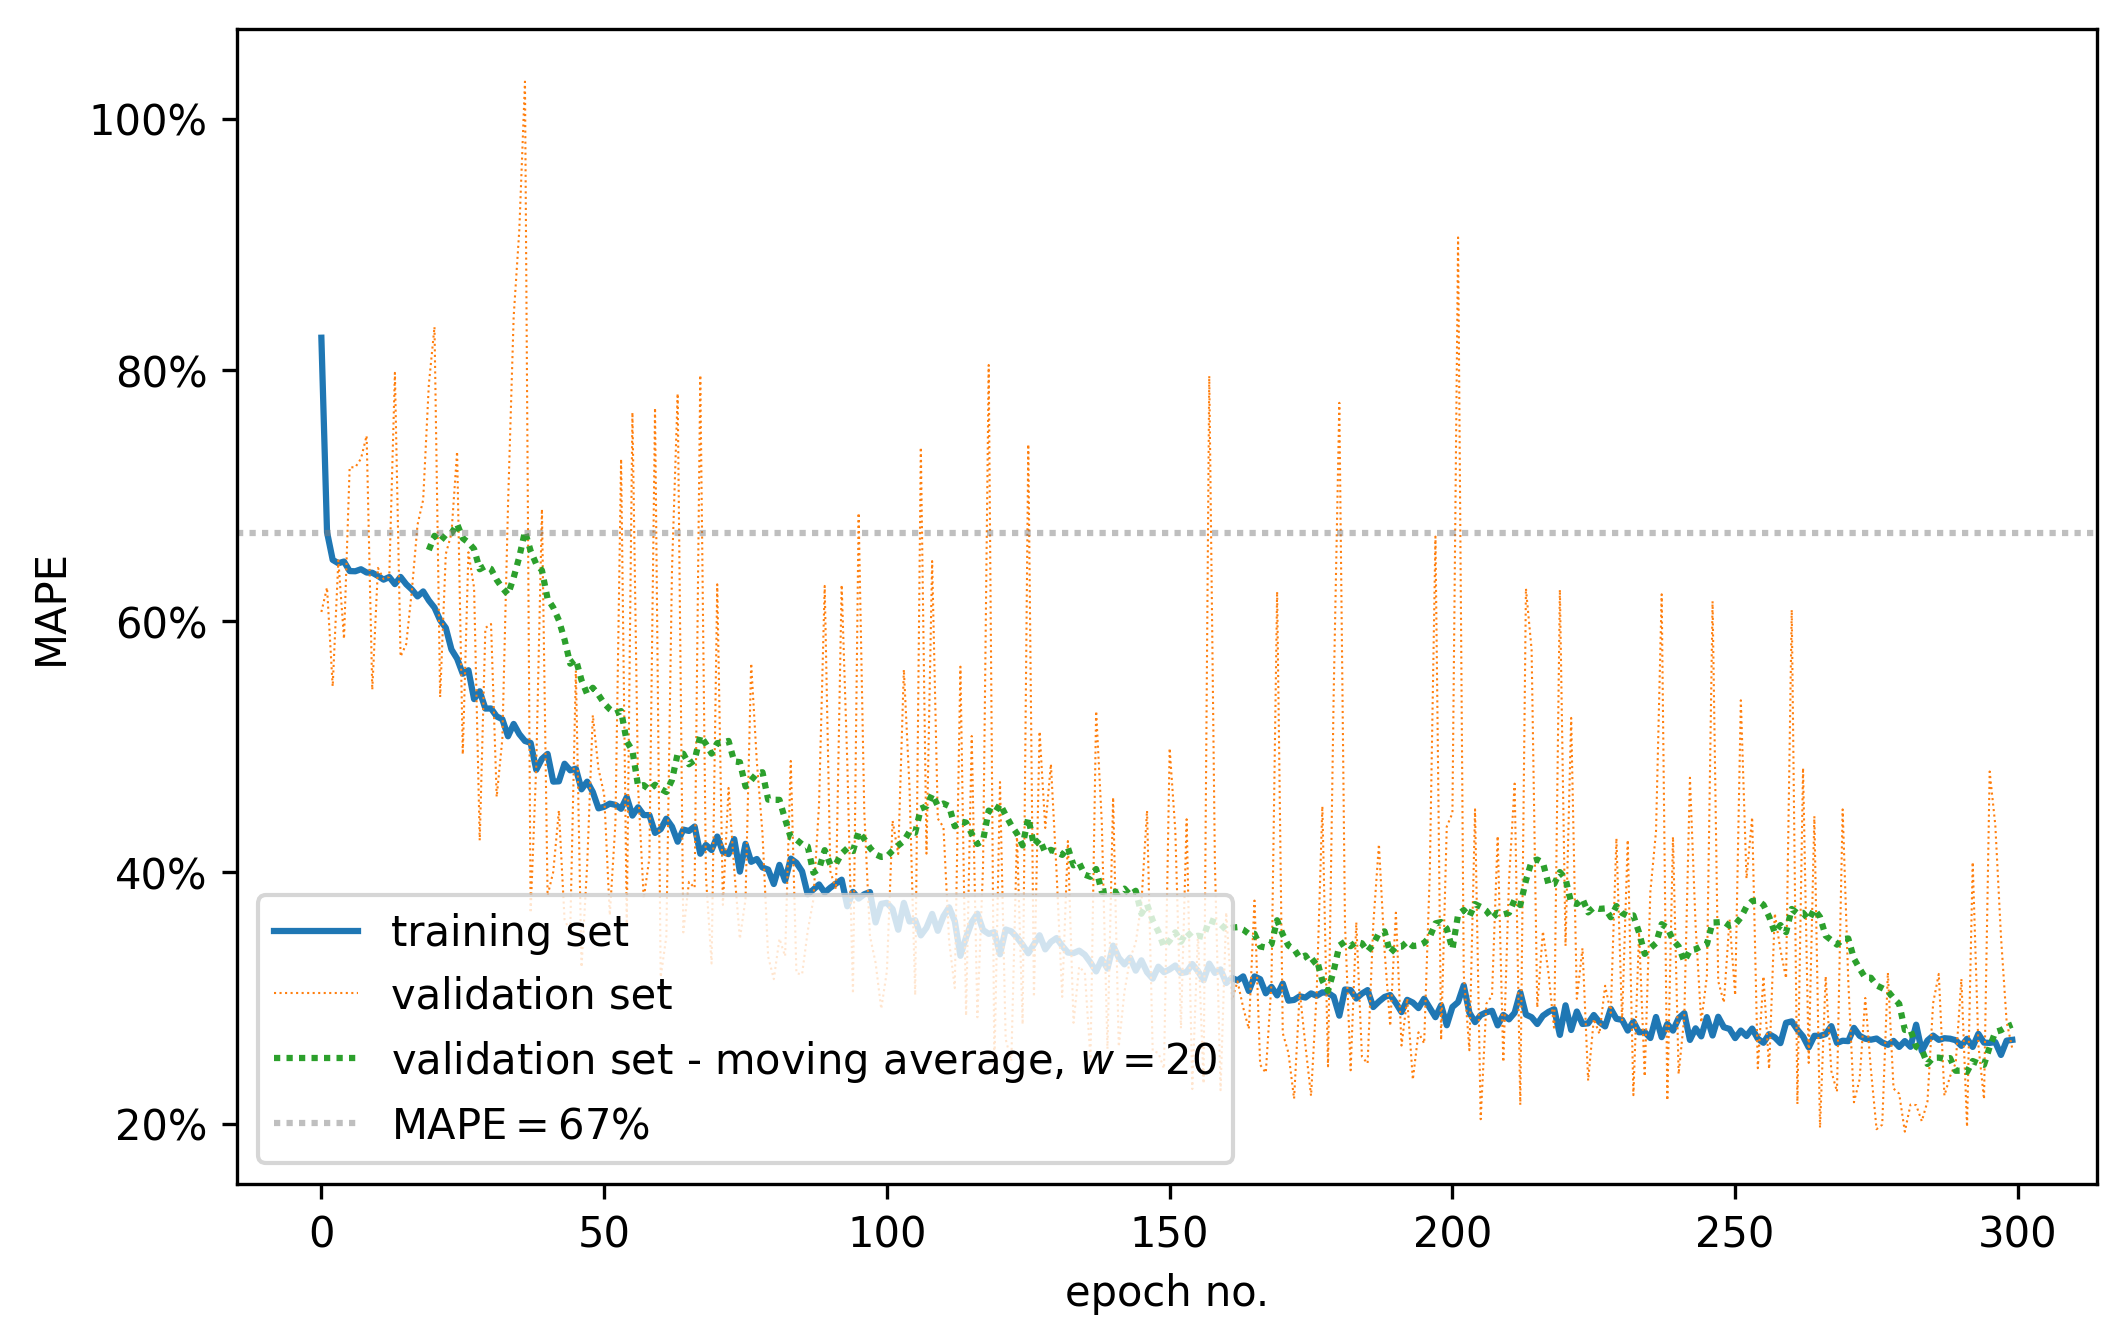

In [35]:
history_df = pd.read_csv(ABS_ROOT_DIR_PATH + 'trained_models/pt/2nd-search-v2/history/' + get_history_filename(pt_second_df, 7))
from common.plot import plot_metric_history
import matplotlib.ticker as tick
plot_metric_history(history_df, metric = 'mean_absolute_percentage_error', legend_loc = 'lower left', dpi=300, figsize=[8,5], y_label='MAPE', y_formatter=tick.PercentFormatter(), hline=67)

In [41]:
inv_pt_first_df = construct_df_from_history_files(ABS_ROOT_DIR_PATH + 'trained_models/pt/inv_pt-1st-search-v2/history/', metric='mean_absolute_percentage_error')
inv_pt_first_df.sort_values('med(test)', ascending=True)[:MAX_ROWS]

,liczba punktów,liczba warstw,liczba neuronów,funkcja aktywacji,warstwa wyjściowa,med(train),med(test),std(test)
15,10,3,128,pol_tanh,convert_to_real_with_abs,39.285776,42.263176,16.447345
2,10,3,128,pol_sigmoid,convert_to_real_with_abs,36.356432,42.949287,15.079278
6,10,3,16,pol_sigmoid,convert_to_real_with_abs,38.365810,43.088223,13.069229
17,10,3,16,pol_tanh,convert_to_real_with_abs,38.026924,45.532494,12.075917
10,10,3,128,cart_relu,convert_to_real_with_abs,36.041103,46.808544,8.317632
9,10,3,128,cart_sigmoid,convert_to_real_with_abs,63.858585,60.577511,29.119644
1,3,3,16,cart_sigmoid,convert_to_real_with_abs,64.229156,61.601255,7.384210
14,10,3,16,cart_relu,convert_to_real_with_abs,63.500158,63.276030,1.968497
7,10,3,16,cart_tanh,convert_to_real_with_abs,64.166645,63.588898,8.379965
12,3,3,128,cart_relu,convert_to_real_with_abs,62.440788,64.125320,4.246535


In [42]:
print(prepare_df_to_latex(inv_pt_first_df, ascending=True).to_latex(index=False, float_format="{:.2f}%".format))

\begin{tabular}{lllrrr}
\toprule
topologia sieci & funkcja aktywacji & warstwa wyjściowa & med(train) & med(test) & std(test) \\
\midrule
10-3x128 & pol_tanh & convert_to_real_with_abs & 39.29% & 42.26% & 16.45% \\
10-3x128 & pol_sigmoid & convert_to_real_with_abs & 36.36% & 42.95% & 15.08% \\
10-3x16 & pol_sigmoid & convert_to_real_with_abs & 38.37% & 43.09% & 13.07% \\
10-3x16 & pol_tanh & convert_to_real_with_abs & 38.03% & 45.53% & 12.08% \\
10-3x128 & cart_relu & convert_to_real_with_abs & 36.04% & 46.81% & 8.32% \\
10-3x128 & cart_sigmoid & convert_to_real_with_abs & 63.86% & 60.58% & 29.12% \\
3-3x16 & cart_sigmoid & convert_to_real_with_abs & 64.23% & 61.60% & 7.38% \\
10-3x16 & cart_relu & convert_to_real_with_abs & 63.50% & 63.28% & 1.97% \\
10-3x16 & cart_tanh & convert_to_real_with_abs & 64.17% & 63.59% & 8.38% \\
3-3x128 & cart_relu & convert_to_real_with_abs & 62.44% & 64.13% & 4.25% \\
3-3x16 & cart_relu & convert_to_real_with_abs & 63.33% & 64.70% & 6.78% \\
10-3x16 & c

In [43]:
inv_pt_second_df = construct_df_from_history_files(ABS_ROOT_DIR_PATH + 'trained_models/pt/inv_pt-2nd-search-v2/history/', metric='mean_absolute_percentage_error')
inv_pt_second_df.sort_values('med(test)', ascending=True)[:MAX_ROWS]

,liczba punktów,liczba warstw,liczba neuronów,funkcja aktywacji,warstwa wyjściowa,med(train),med(test),std(test)
12,10,4,16,pol_sigmoid,convert_to_real_with_abs,25.273065,22.584517,9.796143
2,10,4,128,pol_tanh,convert_to_real_with_abs,26.502195,26.236493,13.629438
23,10,3,8,pol_sigmoid,convert_to_real_with_abs,32.076330,26.363048,10.641871
16,10,2,16,pol_sigmoid,convert_to_real_with_abs,30.724311,27.905344,13.094363
7,10,3,16,pol_sigmoid,convert_to_real_with_abs,27.585787,28.088612,14.394121
15,10,2,16,pol_tanh,convert_to_real_with_abs,28.372261,28.371143,10.853584
19,10,2,8,pol_tanh,convert_to_real_with_abs,31.000995,30.626407,14.209274
18,10,3,128,pol_tanh,convert_to_real_with_abs,28.660976,30.827166,6.387615
10,10,2,128,pol_tanh,convert_to_real_with_abs,32.999243,30.998940,16.423608
3,10,4,8,pol_sigmoid,convert_to_real_with_abs,26.756052,31.593148,16.466707


In [44]:
print(prepare_df_to_latex(inv_pt_second_df, ascending=True).to_latex(index=False, float_format="{:.2f}%".format))

\begin{tabular}{lllrrr}
\toprule
topologia sieci & funkcja aktywacji & warstwa wyjściowa & med(train) & med(test) & std(test) \\
\midrule
10-4x16 & pol_sigmoid & convert_to_real_with_abs & 25.27% & 22.58% & 9.80% \\
10-4x128 & pol_tanh & convert_to_real_with_abs & 26.50% & 26.24% & 13.63% \\
10-3x8 & pol_sigmoid & convert_to_real_with_abs & 32.08% & 26.36% & 10.64% \\
10-2x16 & pol_sigmoid & convert_to_real_with_abs & 30.72% & 27.91% & 13.09% \\
10-3x16 & pol_sigmoid & convert_to_real_with_abs & 27.59% & 28.09% & 14.39% \\
10-2x16 & pol_tanh & convert_to_real_with_abs & 28.37% & 28.37% & 10.85% \\
10-2x8 & pol_tanh & convert_to_real_with_abs & 31.00% & 30.63% & 14.21% \\
10-3x128 & pol_tanh & convert_to_real_with_abs & 28.66% & 30.83% & 6.39% \\
10-2x128 & pol_tanh & convert_to_real_with_abs & 33.00% & 31.00% & 16.42% \\
10-4x8 & pol_sigmoid & convert_to_real_with_abs & 26.76% & 31.59% & 16.47% \\
10-3x16 & pol_tanh & convert_to_real_with_abs & 29.61% & 31.78% & 10.36% \\
10-2x8 & pol_